In [11]:
# Functions
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import holidays
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import random
from sklearn.linear_model import LinearRegression
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import norm
from scipy.interpolate import make_interp_spline


def create_error_rate_data(initial_df, test_start_date, percent_gaps):
    df_orig = initial_df.copy()
    df_test = initial_df.copy()
    df_test_drop = initial_df.copy()
    df_test_drop = df_test_drop[df_test_drop.index >= test_start_date]

    len_deleted = int(len(df_test_drop.dropna()) * (percent_gaps / 100))
    start_index_delete_random = np.random.randint(0, len(df_test_drop.dropna()) - len_deleted)
    long_random_drop_indexes_list = list(range(start_index_delete_random, start_index_delete_random + len_deleted))

    date = df_test_drop.dropna().index[long_random_drop_indexes_list]
    drop_indexes = df_test_drop.index[df_test_drop.index.isin(date)].tolist()
    print(f'Начало вырезки - {drop_indexes[0]}\nКонец - {drop_indexes[-1]}\nДлина вырезки - {len(drop_indexes)}')
    df_for_intervals = df_orig.loc[drop_indexes]

    load_intervals = recive_quantile_internals(df_for_intervals)

    df_test['P_l_interval'] = df_test['P_l'].apply(lambda x: find_interval(x, load_intervals))
    df_orig['P_l_interval'] = df_orig['P_l'].apply(lambda x: find_interval(x, load_intervals))

    df_test['is_droped'] = False
    df_test.loc[df_test.index.isin(date), 'P_l'] = np.nan
    df_test.loc[df_test.index.isin(date), 'is_droped'] = True

    return df_orig, df_test, drop_indexes


def fill_with_linear_regression(df, time_window_years=3):
    print(len(df))
    filled_df = df.copy()
    for time_point in tqdm(filled_df[filled_df['P_l'].isna()].index):
        data = []
        target = []
        for i in range(1, time_window_years + 1):
            previous_year = time_point - pd.DateOffset(years=i)
            next_year = time_point + pd.DateOffset(years=i)

            if previous_year in filled_df.index and not np.isnan(filled_df.loc[previous_year, 'P_l']):
                data.append([-i])
                target.append(filled_df.loc[previous_year, 'P_l'])
            if next_year in filled_df.index and not np.isnan(filled_df.loc[next_year, 'P_l']):
                data.append([i])
                target.append(filled_df.loc[next_year, 'P_l'])

        if data and target:
            regressor = LinearRegression()
            regressor.fit(np.array(data), target)
            filled_df.at[time_point, 'P_l'] = regressor.predict(np.array([[0]]))[0]
        else:
            print('is working now')
            liner_df = filled_df.copy()

            liner_df.loc[:, 'P_l'] = liner_df['P_l'].interpolate(method='linear')

            filled_df.loc[time_point, 'P_l'] = liner_df.loc[time_point, 'P_l']
    return filled_df



def calculate_mape_improved(df_orig, df_predict):
    original_series = df_orig.loc[drop_indexes, 'P_l']
    predicted_series = df_predict.loc[drop_indexes, 'P_l']

    original_series = original_series.astype(float)
    predicted_series = predicted_series.astype(float)

    general_mape = np.mean(np.abs((original_series - predicted_series) / original_series)) * 100
    df_predicted_with_error = df_predict.copy()
    mape_values = []
    for index in drop_indexes:
        original_value = df_orig.loc[index, 'P_l']
        predicted_value = df_predict.loc[index, 'P_l']

        mape = np.abs((original_value - predicted_value) / original_value) * 100
        mape_values.append(mape)

    df_predicted_with_error.loc[drop_indexes, 'MAPE'] = mape_values

    mape_by_interval = {}
    for curr_interval in df_predicted_with_error['P_l_interval'].unique():
        df_curr_interval = df_predicted_with_error[df_predicted_with_error['P_l_interval'] == curr_interval]
        df_curr_interval = df_curr_interval[df_curr_interval['is_droped']==True]
        mape = np.mean(df_curr_interval['MAPE'])
        mape_by_interval[curr_interval] = mape

    mape_by_interval = sorted(mape_by_interval.items(), key=lambda x: x[0])
    mape_by_interval = [item for item in mape_by_interval if not np.isnan(item[0]) and not np.isnan(item[1])]
    mape_by_interval = sorted(mape_by_interval, key=lambda x: x[0])
    return df_predicted_with_error, general_mape, mape_by_interval


def calculate_metrics_per_interval(df_orig, df_filled, metric_name):
    df_orig = df_orig.loc[drop_indexes]  # Remove the comma here
    df_filled = df_filled.loc[drop_indexes]
    metrics_by_interval = {}
    for interval in sorted(df_filled['P_l_interval'].unique()):
        orig_values = df_orig[df_orig['P_l_interval'] == interval]['P_l']
        filled_values = df_filled[df_filled['P_l_interval'] == interval]['P_l']
        if metric_name == 'MAPE':
            metric_value = np.mean(np.abs((orig_values - filled_values) / orig_values)) * 100
        elif metric_name == 'RMSE':
            metric_value = np.sqrt(mean_squared_error(orig_values, filled_values))
        elif metric_name == 'R2':
            metric_value = r2_score(orig_values, filled_values)
        elif metric_name == 'MAE':
            metric_value = mean_absolute_error(orig_values, filled_values)
        metrics_by_interval[interval] = metric_value
    return metrics_by_interval

def calculate_and_plot_metrics(df_orig, df_filled, intervals):
    metrics = ['MAPE', 'RMSE', 'R2', 'MAE']
    results = {}

    for metric in metrics:
        results[metric] = calculate_metrics_per_interval(df_orig, df_filled, metric)

    return results


def find_interval(value, load_intervals):
    for i in range(len(load_intervals)-1):
        low_interval = load_intervals[i]
        hight_interval = load_intervals[i+1]
        if value >= low_interval and value < hight_interval:
            interval_num = int(load_intervals.index(low_interval))
            return interval_num


def create_intervals(df, column='P_l', upper_percentile=99, lower_percentile=1, num_classes=10):
    # Определяем верхнюю границу, используя заданный процентиль
    upper_limit = np.percentile(df[column], upper_percentile)
    
    # Определяем нижнюю границу, используя заданный процентиль
    lower_limit = np.percentile(df[column], lower_percentile)
    
    # Генерируем равномерные интервалы между нижним и верхним пределами
    load_intervals = np.linspace(lower_limit, upper_limit, num_classes + 1)
    load_intervals = load_intervals.tolist()
    
    return load_intervals



def calculate_r_squared(y_true, y_pred):
    SS_res = sum((y_true - y_pred) ** 2)
    SS_tot = sum((y_true - np.mean(y_true)) ** 2)
    r_squared = 1 - (SS_res / SS_tot)
    return r_squared


def recive_quantile_internals(df):
    data = df['P_l']
    q_5 = data.quantile(0.025)
    q_95 = data.quantile(0.975)
    
    trimmed_data = data[(data >= q_5) & (data <= q_95)]
    
    mu, sigma = trimmed_data.mean(), trimmed_data.std()
    
    x = np.linspace(data.min(), data.max(), 100)
    gaussian_curve = norm.pdf(x, mu, sigma)
    
    hist, bins, _ = plt.hist(data, bins=100, density=True, alpha=0.6, color='g')
    
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    
    spl = make_interp_spline(bin_centers, hist, k=3)  
    smooth_bin_centers = np.linspace(bin_centers.min(), bin_centers.max(), 100)  
    smooth_hist = spl(smooth_bin_centers)
    
    plt.plot(smooth_bin_centers, smooth_hist, color='orange', linestyle='-', linewidth=2, label='Top of Bins')
    
    plt.plot(x, gaussian_curve, 'k--', label='Gaussian Curve')
    
    plt.axvline(q_5, color='r', linestyle='--', label='2.5th percentile')
    plt.axvline(q_95, color='r', linestyle='--')
    
    plt.title("Distribution with Trimmed Data by Frequency and Gaussian Curve")
    plt.xlabel("P_l")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True)
    plt.show()

    lower_limit = trimmed_data.min()
    upper_limit = trimmed_data.max()
    load_intervals = np.linspace(lower_limit, upper_limit, 11)
    load_intervals = load_intervals.tolist()

    return load_intervals



In [12]:
# Read data
df_with_season = pd.read_csv('filled_P_l.csv', parse_dates=['time'], index_col='time')

Начало вырезки - 2023-07-19 02:50:00+00:00
Конец - 2023-09-04 16:25:00+00:00
Длина вырезки - 13680


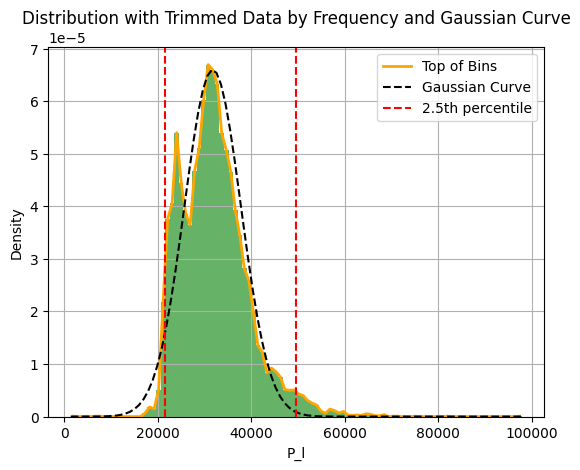

In [13]:
from datetime import datetime
import time


str_date = '2022-02-01'
gaps_percent = 10

date_timestamp = pd.Timestamp(f'{str_date} 00:00:00+0000', tz='UTC')
df_with_season = df_with_season.dropna()
df_all_values = df_with_season.copy()

df_orig, df_test_with_gaps, drop_indexes = create_error_rate_data(df_all_values, date_timestamp, gaps_percent)

In [14]:
# Marking for 10 intervals from Pmin to Pmax
# Pmin and Pmax are taken from the test interval starting from str_date and long in gaps_percent %

df_only_gaps = df_orig.loc[drop_indexes]
load_intervals = create_intervals(df_only_gaps)

# Нумеровка интервалов исходя из того что интервалы были обозначены
#в расках тестовой вырезки
#df_only_gaps['P_l_interval'] = df_only_gaps['P_l'].apply(lambda x: find_interval(x, load_intervals))


In [15]:
# Filling gaps using linear regression
filled_df = fill_with_linear_regression(df_test_with_gaps)


621706


  9%|███▎                                  | 1182/13680 [00:00<00:07, 1698.80it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 10%|███▊                                   | 1352/13680 [00:01<00:24, 497.24it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working

 11%|████▏                                  | 1475/13680 [00:03<01:14, 163.42it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working

 11%|████▍                                  | 1561/13680 [00:05<01:44, 116.12it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 12%|████▋                                   | 1622/13680 [00:06<02:04, 97.20it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 12%|████▊                                   | 1666/13680 [00:07<02:18, 86.74it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 12%|████▉                                   | 1699/13680 [00:08<02:29, 79.96it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 13%|█████                                   | 1724/13680 [00:08<02:39, 75.18it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 13%|█████                                   | 1743/13680 [00:08<02:46, 71.65it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 13%|█████▏                                  | 1758/13680 [00:09<02:53, 68.84it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 13%|█████▏                                  | 1770/13680 [00:09<02:59, 66.51it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 13%|█████▏                                  | 1780/13680 [00:09<03:04, 64.54it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 13%|█████▏                                  | 1789/13680 [00:09<03:09, 62.73it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 13%|█████▎                                  | 1804/13680 [00:10<03:18, 59.75it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 13%|█████▎                                  | 1811/13680 [00:10<03:23, 58.47it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 13%|█████▎                                  | 1824/13680 [00:10<03:29, 56.50it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 13%|█████▎                                  | 1836/13680 [00:10<03:34, 55.14it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 14%|█████▍                                  | 1848/13680 [00:10<03:38, 54.19it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 14%|█████▍                                  | 1854/13680 [00:10<03:39, 53.94it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 14%|█████▍                                  | 1866/13680 [00:11<03:40, 53.61it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 14%|█████▍                                  | 1878/13680 [00:11<03:40, 53.41it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 14%|█████▌                                  | 1890/13680 [00:11<03:40, 53.36it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 14%|█████▌                                  | 1902/13680 [00:11<03:40, 53.34it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 14%|█████▌                                  | 1914/13680 [00:12<03:40, 53.31it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 14%|█████▌                                  | 1920/13680 [00:12<03:40, 53.21it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 14%|█████▋                                  | 1932/13680 [00:12<03:41, 53.08it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 14%|█████▋                                  | 1944/13680 [00:12<03:40, 53.18it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 14%|█████▋                                  | 1956/13680 [00:12<03:39, 53.32it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 14%|█████▊                                  | 1968/13680 [00:13<03:39, 53.38it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 14%|█████▊                                  | 1980/13680 [00:13<03:39, 53.35it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 15%|█████▊                                  | 1986/13680 [00:13<03:39, 53.33it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 15%|█████▊                                  | 1998/13680 [00:13<03:38, 53.34it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 15%|█████▉                                  | 2010/13680 [00:13<03:39, 53.24it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 15%|█████▉                                  | 2022/13680 [00:14<03:39, 53.23it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 15%|█████▉                                  | 2034/13680 [00:14<03:38, 53.31it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 15%|█████▉                                  | 2046/13680 [00:14<03:38, 53.31it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 15%|██████                                  | 2052/13680 [00:14<03:38, 53.24it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 15%|██████                                  | 2064/13680 [00:14<03:37, 53.32it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 15%|██████                                  | 2076/13680 [00:15<03:37, 53.29it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 15%|██████                                  | 2088/13680 [00:15<03:37, 53.31it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 15%|██████▏                                 | 2100/13680 [00:15<03:37, 53.34it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 15%|██████▏                                 | 2112/13680 [00:15<03:36, 53.32it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 15%|██████▏                                 | 2118/13680 [00:15<03:36, 53.29it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 16%|██████▏                                 | 2130/13680 [00:16<03:36, 53.33it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 16%|██████▎                                 | 2142/13680 [00:16<03:36, 53.30it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 16%|██████▎                                 | 2154/13680 [00:16<03:36, 53.29it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 16%|██████▎                                 | 2166/13680 [00:16<03:35, 53.33it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 16%|██████▎                                 | 2178/13680 [00:17<03:35, 53.26it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 16%|██████▍                                 | 2184/13680 [00:17<03:35, 53.25it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 16%|██████▍                                 | 2196/13680 [00:17<03:35, 53.24it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 16%|██████▍                                 | 2208/13680 [00:17<03:35, 53.24it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 16%|██████▍                                 | 2220/13680 [00:17<03:34, 53.31it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 16%|██████▌                                 | 2232/13680 [00:18<03:34, 53.30it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 16%|██████▌                                 | 2244/13680 [00:18<03:34, 53.29it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 16%|██████▌                                 | 2250/13680 [00:18<03:34, 53.26it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 17%|██████▌                                 | 2262/13680 [00:18<03:34, 53.25it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 17%|██████▋                                 | 2274/13680 [00:18<03:34, 53.16it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 17%|██████▋                                 | 2286/13680 [00:19<03:34, 53.16it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 17%|██████▋                                 | 2298/13680 [00:19<03:33, 53.19it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 17%|██████▊                                 | 2310/13680 [00:19<03:33, 53.16it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 17%|██████▊                                 | 2316/13680 [00:19<03:33, 53.12it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 17%|██████▊                                 | 2328/13680 [00:19<03:33, 53.10it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 17%|██████▊                                 | 2340/13680 [00:20<03:33, 53.08it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 17%|██████▉                                 | 2352/13680 [00:20<03:33, 53.00it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 17%|██████▉                                 | 2364/13680 [00:20<03:34, 52.82it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 17%|██████▉                                 | 2376/13680 [00:20<03:33, 52.85it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 17%|██████▉                                 | 2382/13680 [00:20<03:34, 52.78it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 18%|███████                                 | 2394/13680 [00:21<03:33, 52.91it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 18%|███████                                 | 2406/13680 [00:21<03:33, 52.91it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 18%|███████                                 | 2418/13680 [00:21<03:32, 53.00it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 18%|███████                                 | 2430/13680 [00:21<03:32, 53.00it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 18%|███████▏                                | 2442/13680 [00:22<03:31, 53.04it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 18%|███████▏                                | 2448/13680 [00:22<03:31, 53.11it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 18%|███████▏                                | 2460/13680 [00:22<03:31, 53.17it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 18%|███████▏                                | 2472/13680 [00:22<03:30, 53.16it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 18%|███████▎                                | 2484/13680 [00:22<03:31, 52.97it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 18%|███████▎                                | 2496/13680 [00:23<03:31, 52.96it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 18%|███████▎                                | 2508/13680 [00:23<03:30, 53.11it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 18%|███████▎                                | 2514/13680 [00:23<03:30, 53.13it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 18%|███████▍                                | 2526/13680 [00:23<03:29, 53.19it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 19%|███████▍                                | 2538/13680 [00:23<03:29, 53.20it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 19%|███████▍                                | 2550/13680 [00:24<03:28, 53.26it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 19%|███████▍                                | 2562/13680 [00:24<03:28, 53.30it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 19%|███████▌                                | 2574/13680 [00:24<03:28, 53.35it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 19%|███████▌                                | 2580/13680 [00:24<03:28, 53.25it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 19%|███████▌                                | 2592/13680 [00:24<03:28, 53.29it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 19%|███████▌                                | 2604/13680 [00:25<03:27, 53.27it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 19%|███████▋                                | 2616/13680 [00:25<03:27, 53.31it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 19%|███████▋                                | 2628/13680 [00:25<03:27, 53.33it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 19%|███████▋                                | 2640/13680 [00:25<03:27, 53.30it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 19%|███████▋                                | 2646/13680 [00:25<03:27, 53.25it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 19%|███████▊                                | 2658/13680 [00:26<03:27, 53.24it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 20%|███████▊                                | 2670/13680 [00:26<03:26, 53.26it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 20%|███████▊                                | 2682/13680 [00:26<03:26, 53.25it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 20%|███████▉                                | 2694/13680 [00:26<03:26, 53.22it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 20%|███████▉                                | 2706/13680 [00:26<03:26, 53.18it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 20%|███████▉                                | 2712/13680 [00:27<03:26, 53.09it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 20%|███████▉                                | 2724/13680 [00:27<03:26, 53.09it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 20%|████████                                | 2736/13680 [00:27<03:26, 53.07it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 20%|████████                                | 2748/13680 [00:27<03:26, 53.04it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 20%|████████                                | 2760/13680 [00:27<03:26, 52.96it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 20%|████████                                | 2772/13680 [00:28<03:26, 52.81it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 20%|████████                                | 2778/13680 [00:28<03:26, 52.86it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 20%|████████▏                               | 2790/13680 [00:28<03:25, 52.98it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 20%|████████▏                               | 2802/13680 [00:28<03:25, 53.05it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 21%|████████▏                               | 2814/13680 [00:29<03:25, 52.95it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 21%|████████▎                               | 2826/13680 [00:29<03:25, 52.86it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 21%|████████▎                               | 2838/13680 [00:29<03:24, 52.99it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 21%|████████▎                               | 2844/13680 [00:29<03:24, 53.01it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 21%|████████▎                               | 2856/13680 [00:29<03:24, 53.02it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 21%|████████▍                               | 2868/13680 [00:30<03:23, 53.05it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 21%|████████▍                               | 2880/13680 [00:30<03:23, 53.11it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 21%|████████▍                               | 2892/13680 [00:30<03:23, 52.98it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 21%|████████▍                               | 2904/13680 [00:30<03:22, 53.11it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 21%|████████▌                               | 2910/13680 [00:30<03:22, 53.13it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 21%|████████▌                               | 2922/13680 [00:31<03:22, 53.06it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 21%|████████▌                               | 2934/13680 [00:31<03:22, 53.08it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 22%|████████▌                               | 2946/13680 [00:31<03:21, 53.15it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 22%|████████▋                               | 2958/13680 [00:31<03:21, 53.28it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 22%|████████▋                               | 2970/13680 [00:31<03:21, 53.28it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 22%|████████▋                               | 2976/13680 [00:32<03:20, 53.28it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 22%|████████▋                               | 2988/13680 [00:32<03:20, 53.27it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 22%|████████▊                               | 3000/13680 [00:32<03:20, 53.24it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 22%|████████▊                               | 3012/13680 [00:32<03:20, 53.28it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 22%|████████▊                               | 3024/13680 [00:32<03:20, 53.19it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 22%|████████▉                               | 3036/13680 [00:33<03:20, 53.00it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 22%|████████▉                               | 3042/13680 [00:33<03:20, 53.06it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 22%|████████▉                               | 3054/13680 [00:33<03:19, 53.17it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 22%|████████▉                               | 3066/13680 [00:33<03:19, 53.20it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 22%|█████████                               | 3078/13680 [00:33<03:19, 53.18it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 23%|█████████                               | 3090/13680 [00:34<03:18, 53.28it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 23%|█████████                               | 3102/13680 [00:34<03:18, 53.30it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 23%|█████████                               | 3108/13680 [00:34<03:18, 53.27it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 23%|█████████                               | 3120/13680 [00:34<03:17, 53.34it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 23%|█████████▏                              | 3132/13680 [00:34<03:17, 53.28it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 23%|█████████▏                              | 3144/13680 [00:35<03:17, 53.29it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 23%|█████████▏                              | 3156/13680 [00:35<03:17, 53.28it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 23%|█████████▎                              | 3168/13680 [00:35<03:17, 53.23it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 23%|█████████▎                              | 3174/13680 [00:35<03:17, 53.15it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 23%|█████████▎                              | 3186/13680 [00:36<03:17, 53.16it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 23%|█████████▎                              | 3198/13680 [00:36<03:17, 53.11it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 23%|█████████▍                              | 3210/13680 [00:36<03:17, 53.05it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 24%|█████████▍                              | 3222/13680 [00:36<03:17, 52.97it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 24%|█████████▍                              | 3234/13680 [00:36<03:18, 52.74it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 24%|█████████▍                              | 3240/13680 [00:37<03:18, 52.62it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 24%|█████████▌                              | 3252/13680 [00:37<03:18, 52.51it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 24%|█████████▌                              | 3264/13680 [00:37<03:18, 52.56it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 24%|█████████▌                              | 3276/13680 [00:37<03:17, 52.58it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 24%|█████████▌                              | 3288/13680 [00:37<03:17, 52.62it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 24%|█████████▋                              | 3300/13680 [00:38<03:17, 52.62it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 24%|█████████▋                              | 3306/13680 [00:38<03:17, 52.64it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 24%|█████████▋                              | 3318/13680 [00:38<03:16, 52.72it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 24%|█████████▋                              | 3330/13680 [00:38<03:16, 52.72it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 24%|█████████▊                              | 3342/13680 [00:38<03:16, 52.73it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 25%|█████████▊                              | 3354/13680 [00:39<03:16, 52.66it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 25%|█████████▊                              | 3366/13680 [00:39<03:15, 52.64it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 25%|█████████▊                              | 3372/13680 [00:39<03:15, 52.67it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 25%|█████████▉                              | 3384/13680 [00:39<03:15, 52.71it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 25%|█████████▉                              | 3396/13680 [00:39<03:15, 52.68it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 25%|█████████▉                              | 3408/13680 [00:40<03:14, 52.88it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 25%|██████████                              | 3420/13680 [00:40<03:13, 52.99it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 25%|██████████                              | 3432/13680 [00:40<03:13, 53.01it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 25%|██████████                              | 3438/13680 [00:40<03:13, 52.91it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 25%|██████████                              | 3450/13680 [00:41<03:13, 52.98it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 25%|██████████                              | 3462/13680 [00:41<03:12, 53.09it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 25%|██████████▏                             | 3474/13680 [00:41<03:12, 53.06it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 25%|██████████▏                             | 3486/13680 [00:41<03:12, 53.09it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 26%|██████████▏                             | 3498/13680 [00:41<03:11, 53.20it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 26%|██████████▏                             | 3504/13680 [00:42<03:11, 53.20it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 26%|██████████▎                             | 3516/13680 [00:42<03:11, 53.21it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 26%|██████████▎                             | 3528/13680 [00:42<03:11, 52.99it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 26%|██████████▎                             | 3540/13680 [00:42<03:10, 53.14it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 26%|██████████▍                             | 3552/13680 [00:42<03:10, 53.22it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 26%|██████████▍                             | 3564/13680 [00:43<03:11, 52.96it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 26%|██████████▍                             | 3570/13680 [00:43<03:10, 53.08it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 26%|██████████▍                             | 3582/13680 [00:43<03:09, 53.21it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 26%|██████████▌                             | 3594/13680 [00:43<03:09, 53.21it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 26%|██████████▌                             | 3606/13680 [00:43<03:09, 53.28it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 26%|██████████▌                             | 3618/13680 [00:44<03:08, 53.33it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 27%|██████████▌                             | 3630/13680 [00:44<03:08, 53.40it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 27%|██████████▋                             | 3636/13680 [00:44<03:08, 53.29it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 27%|██████████▋                             | 3648/13680 [00:44<03:08, 53.28it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 27%|██████████▋                             | 3660/13680 [00:44<03:08, 53.22it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 27%|██████████▋                             | 3672/13680 [00:45<03:07, 53.27it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 27%|██████████▊                             | 3684/13680 [00:45<03:07, 53.33it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 27%|██████████▊                             | 3696/13680 [00:45<03:07, 53.30it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 27%|██████████▊                             | 3702/13680 [00:45<03:07, 53.28it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 27%|██████████▊                             | 3714/13680 [00:45<03:06, 53.33it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 27%|██████████▉                             | 3726/13680 [00:46<03:06, 53.35it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 27%|██████████▉                             | 3738/13680 [00:46<03:06, 53.42it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 27%|██████████▉                             | 3750/13680 [00:46<03:05, 53.46it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 28%|███████████                             | 3762/13680 [00:46<03:05, 53.47it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 28%|███████████                             | 3768/13680 [00:46<03:05, 53.42it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 28%|███████████                             | 3780/13680 [00:47<03:05, 53.39it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 28%|███████████                             | 3792/13680 [00:47<03:05, 53.39it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 28%|███████████                             | 3804/13680 [00:47<03:04, 53.39it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 28%|███████████▏                            | 3816/13680 [00:47<03:04, 53.44it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 28%|███████████▏                            | 3828/13680 [00:48<03:05, 53.24it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 28%|███████████▏                            | 3834/13680 [00:48<03:04, 53.31it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 28%|███████████▏                            | 3846/13680 [00:48<03:04, 53.26it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 28%|███████████▎                            | 3858/13680 [00:48<03:04, 53.31it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 28%|███████████▎                            | 3870/13680 [00:48<03:03, 53.34it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 28%|███████████▎                            | 3882/13680 [00:49<03:03, 53.36it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 28%|███████████▍                            | 3894/13680 [00:49<03:03, 53.29it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 29%|███████████▍                            | 3900/13680 [00:49<03:03, 53.25it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 29%|███████████▍                            | 3912/13680 [00:49<03:03, 53.27it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 29%|███████████▍                            | 3924/13680 [00:49<03:02, 53.34it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 29%|███████████▌                            | 3936/13680 [00:50<03:02, 53.39it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 29%|███████████▌                            | 3948/13680 [00:50<03:02, 53.38it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 29%|███████████▌                            | 3960/13680 [00:50<03:02, 53.36it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 29%|███████████▌                            | 3966/13680 [00:50<03:02, 53.34it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 29%|███████████▋                            | 3978/13680 [00:50<03:02, 53.22it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 29%|███████████▋                            | 3990/13680 [00:51<03:02, 53.18it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 29%|███████████▋                            | 4002/13680 [00:51<03:01, 53.34it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 29%|███████████▋                            | 4014/13680 [00:51<03:00, 53.42it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 29%|███████████▊                            | 4026/13680 [00:51<03:00, 53.40it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 29%|███████████▊                            | 4032/13680 [00:51<03:00, 53.36it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 30%|███████████▊                            | 4044/13680 [00:52<03:00, 53.36it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 30%|███████████▊                            | 4056/13680 [00:52<03:00, 53.32it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 30%|███████████▉                            | 4068/13680 [00:52<03:00, 53.38it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 30%|███████████▉                            | 4080/13680 [00:52<02:59, 53.36it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 30%|███████████▉                            | 4092/13680 [00:53<02:59, 53.41it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 30%|███████████▉                            | 4098/13680 [00:53<02:59, 53.41it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 30%|████████████                            | 4110/13680 [00:53<02:59, 53.37it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 30%|████████████                            | 4122/13680 [00:53<02:59, 53.38it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 30%|████████████                            | 4134/13680 [00:53<02:58, 53.43it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 30%|████████████                            | 4146/13680 [00:54<02:58, 53.45it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 30%|████████████▏                           | 4158/13680 [00:54<02:58, 53.45it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 30%|████████████▏                           | 4164/13680 [00:54<02:58, 53.40it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 31%|████████████▏                           | 4176/13680 [00:54<02:58, 53.34it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 31%|████████████▏                           | 4188/13680 [00:54<02:57, 53.42it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 31%|████████████▎                           | 4200/13680 [00:55<02:57, 53.46it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 31%|████████████▎                           | 4212/13680 [00:55<02:57, 53.45it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 31%|████████████▎                           | 4224/13680 [00:55<02:56, 53.46it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 31%|████████████▎                           | 4230/13680 [00:55<02:56, 53.44it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 31%|████████████▍                           | 4242/13680 [00:55<02:56, 53.51it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 31%|████████████▍                           | 4254/13680 [00:56<02:56, 53.50it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 31%|████████████▍                           | 4266/13680 [00:56<02:55, 53.51it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 31%|████████████▌                           | 4278/13680 [00:56<02:55, 53.51it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 31%|████████████▌                           | 4290/13680 [00:56<02:55, 53.53it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 31%|████████████▌                           | 4296/13680 [00:56<02:55, 53.48it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 31%|████████████▌                           | 4308/13680 [00:57<02:55, 53.54it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 32%|████████████▋                           | 4320/13680 [00:57<02:54, 53.53it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 32%|████████████▋                           | 4332/13680 [00:57<02:54, 53.48it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 32%|████████████▋                           | 4344/13680 [00:57<02:54, 53.51it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 32%|████████████▋                           | 4356/13680 [00:57<02:54, 53.49it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 32%|████████████▊                           | 4362/13680 [00:58<02:54, 53.46it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 32%|████████████▊                           | 4374/13680 [00:58<02:54, 53.47it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 32%|████████████▊                           | 4386/13680 [00:58<02:53, 53.46it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 32%|████████████▊                           | 4398/13680 [00:58<02:53, 53.48it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 32%|████████████▉                           | 4410/13680 [00:59<02:53, 53.45it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 32%|████████████▉                           | 4422/13680 [00:59<02:53, 53.46it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 32%|████████████▉                           | 4428/13680 [00:59<02:53, 53.44it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 32%|████████████▉                           | 4440/13680 [00:59<02:52, 53.46it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 33%|█████████████                           | 4452/13680 [00:59<02:52, 53.43it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 33%|█████████████                           | 4464/13680 [01:00<02:52, 53.46it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 33%|█████████████                           | 4476/13680 [01:00<02:52, 53.48it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 33%|█████████████                           | 4488/13680 [01:00<02:51, 53.45it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 33%|█████████████▏                          | 4494/13680 [01:00<02:51, 53.47it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 33%|█████████████▏                          | 4506/13680 [01:00<02:51, 53.52it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 33%|█████████████▏                          | 4518/13680 [01:01<02:51, 53.53it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 33%|█████████████▏                          | 4530/13680 [01:01<02:50, 53.53it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 33%|█████████████▎                          | 4542/13680 [01:01<02:50, 53.52it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 33%|█████████████▎                          | 4554/13680 [01:01<02:50, 53.55it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 33%|█████████████▎                          | 4560/13680 [01:01<02:50, 53.56it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 33%|█████████████▎                          | 4572/13680 [01:02<02:50, 53.55it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 34%|█████████████▍                          | 4584/13680 [01:02<02:49, 53.57it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 34%|█████████████▍                          | 4596/13680 [01:02<02:49, 53.58it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 34%|█████████████▍                          | 4608/13680 [01:02<02:49, 53.53it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 34%|█████████████▌                          | 4620/13680 [01:02<02:49, 53.50it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 34%|█████████████▌                          | 4626/13680 [01:03<02:49, 53.52it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 34%|█████████████▌                          | 4638/13680 [01:03<02:48, 53.53it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 34%|█████████████▌                          | 4650/13680 [01:03<02:48, 53.55it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 34%|█████████████▋                          | 4662/13680 [01:03<02:48, 53.50it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 34%|█████████████▋                          | 4674/13680 [01:03<02:48, 53.57it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 34%|█████████████▋                          | 4686/13680 [01:04<02:47, 53.57it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 34%|█████████████▋                          | 4692/13680 [01:04<02:47, 53.53it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 34%|█████████████▊                          | 4704/13680 [01:04<02:47, 53.59it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 34%|█████████████▊                          | 4716/13680 [01:04<02:47, 53.49it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 35%|█████████████▊                          | 4728/13680 [01:04<02:47, 53.47it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 35%|█████████████▊                          | 4740/13680 [01:05<02:47, 53.46it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 35%|█████████████▉                          | 4752/13680 [01:05<02:46, 53.51it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 35%|█████████████▉                          | 4758/13680 [01:05<02:46, 53.47it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 35%|█████████████▉                          | 4770/13680 [01:05<02:46, 53.41it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 35%|█████████████▉                          | 4782/13680 [01:05<02:46, 53.43it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 35%|██████████████                          | 4794/13680 [01:06<02:46, 53.41it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 35%|██████████████                          | 4806/13680 [01:06<02:46, 53.45it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 35%|██████████████                          | 4818/13680 [01:06<02:45, 53.53it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 35%|██████████████                          | 4824/13680 [01:06<02:45, 53.44it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 35%|██████████████▏                         | 4836/13680 [01:06<02:45, 53.43it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 35%|██████████████▏                         | 4848/13680 [01:07<02:44, 53.53it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 36%|██████████████▏                         | 4860/13680 [01:07<02:44, 53.54it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 36%|██████████████▏                         | 4872/13680 [01:07<02:44, 53.50it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 36%|██████████████▎                         | 4884/13680 [01:07<02:44, 53.52it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 36%|██████████████▎                         | 4890/13680 [01:07<02:44, 53.48it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 36%|██████████████▎                         | 4902/13680 [01:08<02:44, 53.47it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 36%|██████████████▎                         | 4914/13680 [01:08<02:43, 53.47it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 36%|██████████████▍                         | 4926/13680 [01:08<02:43, 53.47it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 36%|██████████████▍                         | 4938/13680 [01:08<02:43, 53.47it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 36%|██████████████▍                         | 4950/13680 [01:09<02:43, 53.47it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 36%|██████████████▍                         | 4956/13680 [01:09<02:43, 53.42it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 36%|██████████████▌                         | 4968/13680 [01:09<02:43, 53.43it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 36%|██████████████▌                         | 4980/13680 [01:09<02:42, 53.45it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 36%|██████████████▌                         | 4992/13680 [01:09<02:42, 53.47it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 37%|██████████████▋                         | 5004/13680 [01:10<02:42, 53.49it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 37%|██████████████▋                         | 5016/13680 [01:10<02:41, 53.53it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 37%|██████████████▋                         | 5022/13680 [01:10<02:41, 53.54it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 37%|██████████████▋                         | 5034/13680 [01:10<02:41, 53.58it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 37%|██████████████▊                         | 5046/13680 [01:10<02:41, 53.58it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 37%|██████████████▊                         | 5058/13680 [01:11<02:40, 53.58it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 37%|██████████████▊                         | 5070/13680 [01:11<02:40, 53.58it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 37%|██████████████▊                         | 5082/13680 [01:11<02:40, 53.58it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 37%|██████████████▉                         | 5088/13680 [01:11<02:40, 53.52it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 37%|██████████████▉                         | 5100/13680 [01:11<02:40, 53.57it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 37%|██████████████▉                         | 5112/13680 [01:12<02:40, 53.54it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 37%|██████████████▉                         | 5124/13680 [01:12<02:39, 53.53it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 38%|███████████████                         | 5136/13680 [01:12<02:39, 53.58it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 38%|███████████████                         | 5148/13680 [01:12<02:39, 53.57it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 38%|███████████████                         | 5154/13680 [01:12<02:39, 53.50it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 38%|███████████████                         | 5166/13680 [01:13<02:39, 53.53it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 38%|███████████████▏                        | 5178/13680 [01:13<02:38, 53.51it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 38%|███████████████▏                        | 5190/13680 [01:13<02:38, 53.54it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 38%|███████████████▏                        | 5202/13680 [01:13<02:38, 53.60it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 38%|███████████████▏                        | 5214/13680 [01:14<02:37, 53.59it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 38%|███████████████▎                        | 5220/13680 [01:14<02:38, 53.53it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 38%|███████████████▎                        | 5232/13680 [01:14<02:37, 53.55it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 38%|███████████████▎                        | 5244/13680 [01:14<02:37, 53.55it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 38%|███████████████▎                        | 5256/13680 [01:14<02:37, 53.54it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 39%|███████████████▍                        | 5268/13680 [01:15<02:36, 53.59it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 39%|███████████████▍                        | 5280/13680 [01:15<02:36, 53.54it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 39%|███████████████▍                        | 5286/13680 [01:15<02:36, 53.52it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 39%|███████████████▍                        | 5298/13680 [01:15<02:36, 53.55it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 39%|███████████████▌                        | 5310/13680 [01:15<02:36, 53.51it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 39%|███████████████▌                        | 5322/13680 [01:16<02:36, 53.52it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 39%|███████████████▌                        | 5334/13680 [01:16<02:35, 53.58it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 39%|███████████████▋                        | 5346/13680 [01:16<02:35, 53.60it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 39%|███████████████▋                        | 5352/13680 [01:16<02:35, 53.55it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 39%|███████████████▋                        | 5364/13680 [01:16<02:35, 53.65it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 39%|███████████████▋                        | 5376/13680 [01:17<02:34, 53.67it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 39%|███████████████▊                        | 5388/13680 [01:17<02:34, 53.57it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 39%|███████████████▊                        | 5400/13680 [01:17<02:34, 53.54it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 40%|███████████████▊                        | 5412/13680 [01:17<02:34, 53.54it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 40%|███████████████▊                        | 5418/13680 [01:17<02:34, 53.49it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 40%|███████████████▉                        | 5430/13680 [01:18<02:34, 53.51it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 40%|███████████████▉                        | 5442/13680 [01:18<02:33, 53.53it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 40%|███████████████▉                        | 5454/13680 [01:18<02:33, 53.60it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 40%|███████████████▉                        | 5466/13680 [01:18<02:33, 53.56it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 40%|████████████████                        | 5478/13680 [01:18<02:33, 53.53it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 40%|████████████████                        | 5484/13680 [01:19<02:33, 53.47it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 40%|████████████████                        | 5496/13680 [01:19<02:32, 53.49it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 40%|████████████████                        | 5508/13680 [01:19<02:32, 53.51it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 40%|████████████████▏                       | 5520/13680 [01:19<02:32, 53.57it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 40%|████████████████▏                       | 5532/13680 [01:19<02:32, 53.60it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 41%|████████████████▏                       | 5544/13680 [01:20<02:31, 53.60it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 41%|████████████████▏                       | 5550/13680 [01:20<02:31, 53.60it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 41%|████████████████▎                       | 5562/13680 [01:20<02:31, 53.57it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 41%|████████████████▎                       | 5574/13680 [01:20<02:31, 53.58it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 41%|████████████████▎                       | 5586/13680 [01:20<02:31, 53.58it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 41%|████████████████▎                       | 5598/13680 [01:21<02:30, 53.59it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 41%|████████████████▍                       | 5610/13680 [01:21<02:30, 53.54it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 41%|████████████████▍                       | 5616/13680 [01:21<02:30, 53.47it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 41%|████████████████▍                       | 5628/13680 [01:21<02:30, 53.51it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 41%|████████████████▍                       | 5640/13680 [01:21<02:30, 53.48it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 41%|████████████████▌                       | 5652/13680 [01:22<02:29, 53.55it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 41%|████████████████▌                       | 5664/13680 [01:22<02:29, 53.52it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 41%|████████████████▌                       | 5676/13680 [01:22<02:29, 53.57it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 42%|████████████████▌                       | 5682/13680 [01:22<02:29, 53.54it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 42%|████████████████▋                       | 5694/13680 [01:23<02:29, 53.57it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 42%|████████████████▋                       | 5706/13680 [01:23<02:28, 53.57it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 42%|████████████████▋                       | 5718/13680 [01:23<02:28, 53.59it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 42%|████████████████▊                       | 5730/13680 [01:23<02:28, 53.57it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 42%|████████████████▊                       | 5742/13680 [01:23<02:28, 53.56it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 42%|████████████████▊                       | 5748/13680 [01:24<02:28, 53.52it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 42%|████████████████▊                       | 5760/13680 [01:24<02:27, 53.55it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 42%|████████████████▉                       | 5772/13680 [01:24<02:27, 53.54it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 42%|████████████████▉                       | 5784/13680 [01:24<02:27, 53.51it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 42%|████████████████▉                       | 5796/13680 [01:24<02:27, 53.49it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 42%|████████████████▉                       | 5808/13680 [01:25<02:27, 53.50it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 42%|█████████████████                       | 5814/13680 [01:25<02:27, 53.48it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 43%|█████████████████                       | 5826/13680 [01:25<02:26, 53.52it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 43%|█████████████████                       | 5838/13680 [01:25<02:26, 53.56it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 43%|█████████████████                       | 5850/13680 [01:25<02:26, 53.61it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 43%|█████████████████▏                      | 5862/13680 [01:26<02:25, 53.63it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 43%|█████████████████▏                      | 5874/13680 [01:26<02:25, 53.65it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 43%|█████████████████▏                      | 5880/13680 [01:26<02:25, 53.59it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 43%|█████████████████▏                      | 5892/13680 [01:26<02:25, 53.58it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 43%|█████████████████▎                      | 5904/13680 [01:26<02:25, 53.57it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 43%|█████████████████▎                      | 5916/13680 [01:27<02:25, 53.52it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 43%|█████████████████▎                      | 5928/13680 [01:27<02:24, 53.51it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 43%|█████████████████▎                      | 5940/13680 [01:27<02:24, 53.51it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 43%|█████████████████▍                      | 5946/13680 [01:27<02:24, 53.46it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 44%|█████████████████▍                      | 5958/13680 [01:27<02:24, 53.46it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 44%|█████████████████▍                      | 5970/13680 [01:28<02:24, 53.49it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 44%|█████████████████▍                      | 5982/13680 [01:28<02:23, 53.51it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 44%|█████████████████▌                      | 5994/13680 [01:28<02:23, 53.48it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 44%|█████████████████▌                      | 6006/13680 [01:28<02:23, 53.46it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 44%|█████████████████▌                      | 6012/13680 [01:28<02:23, 53.42it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 44%|█████████████████▌                      | 6024/13680 [01:29<02:23, 53.48it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 44%|█████████████████▋                      | 6036/13680 [01:29<02:22, 53.55it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 44%|█████████████████▋                      | 6048/13680 [01:29<02:22, 53.55it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 44%|█████████████████▋                      | 6060/13680 [01:29<02:22, 53.55it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 44%|█████████████████▊                      | 6072/13680 [01:30<02:22, 53.50it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 44%|█████████████████▊                      | 6078/13680 [01:30<02:22, 53.43it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 45%|█████████████████▊                      | 6090/13680 [01:30<02:22, 53.42it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 45%|█████████████████▊                      | 6102/13680 [01:30<02:21, 53.43it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 45%|█████████████████▉                      | 6114/13680 [01:30<02:21, 53.45it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 45%|█████████████████▉                      | 6126/13680 [01:31<02:21, 53.47it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 45%|█████████████████▉                      | 6138/13680 [01:31<02:21, 53.48it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 45%|█████████████████▉                      | 6144/13680 [01:31<02:21, 53.43it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 45%|██████████████████                      | 6156/13680 [01:31<02:20, 53.38it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 45%|██████████████████                      | 6168/13680 [01:31<02:20, 53.34it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 45%|██████████████████                      | 6180/13680 [01:32<02:20, 53.34it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 45%|██████████████████                      | 6192/13680 [01:32<02:20, 53.36it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 45%|██████████████████▏                     | 6204/13680 [01:32<02:20, 53.31it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 45%|██████████████████▏                     | 6210/13680 [01:32<02:20, 53.22it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 45%|██████████████████▏                     | 6222/13680 [01:32<02:20, 53.18it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 46%|██████████████████▏                     | 6234/13680 [01:33<02:20, 52.99it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 46%|██████████████████▎                     | 6246/13680 [01:33<02:20, 52.78it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 46%|██████████████████▎                     | 6258/13680 [01:33<02:20, 52.68it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 46%|██████████████████▎                     | 6270/13680 [01:33<02:21, 52.46it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 46%|██████████████████▎                     | 6276/13680 [01:33<02:21, 52.26it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 46%|██████████████████▍                     | 6288/13680 [01:34<02:22, 51.91it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 46%|██████████████████▍                     | 6300/13680 [01:34<02:24, 51.21it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 46%|██████████████████▍                     | 6312/13680 [01:34<02:25, 50.72it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 46%|██████████████████▍                     | 6324/13680 [01:34<02:25, 50.52it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 46%|██████████████████▌                     | 6336/13680 [01:35<02:26, 50.18it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 46%|██████████████████▌                     | 6342/13680 [01:35<02:26, 50.08it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 46%|██████████████████▌                     | 6354/13680 [01:35<02:26, 49.89it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 47%|██████████████████▌                     | 6364/13680 [01:35<02:28, 49.42it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 47%|██████████████████▋                     | 6374/13680 [01:35<02:27, 49.38it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 47%|██████████████████▋                     | 6384/13680 [01:36<02:27, 49.53it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 47%|██████████████████▋                     | 6399/13680 [01:36<02:26, 49.66it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 47%|██████████████████▋                     | 6404/13680 [01:36<02:26, 49.60it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 47%|██████████████████▊                     | 6414/13680 [01:36<02:26, 49.73it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 47%|██████████████████▊                     | 6429/13680 [01:36<02:25, 49.69it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 47%|██████████████████▊                     | 6439/13680 [01:37<02:25, 49.75it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 47%|██████████████████▊                     | 6445/13680 [01:37<02:24, 49.98it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 47%|██████████████████▉                     | 6457/13680 [01:37<02:23, 50.19it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 47%|██████████████████▉                     | 6469/13680 [01:37<02:22, 50.60it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 47%|██████████████████▉                     | 6481/13680 [01:38<02:21, 50.95it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 47%|██████████████████▉                     | 6493/13680 [01:38<02:20, 51.33it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 48%|███████████████████                     | 6499/13680 [01:38<02:19, 51.44it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 48%|███████████████████                     | 6511/13680 [01:38<02:18, 51.68it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 48%|███████████████████                     | 6523/13680 [01:38<02:18, 51.84it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 48%|███████████████████                     | 6535/13680 [01:39<02:17, 52.04it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 48%|███████████████████▏                    | 6547/13680 [01:39<02:16, 52.18it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 48%|███████████████████▏                    | 6559/13680 [01:39<02:16, 52.11it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 48%|███████████████████▏                    | 6565/13680 [01:39<02:16, 52.03it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 48%|███████████████████▏                    | 6577/13680 [01:39<02:15, 52.35it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 48%|███████████████████▎                    | 6589/13680 [01:40<02:14, 52.68it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 48%|███████████████████▎                    | 6601/13680 [01:40<02:13, 52.88it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 48%|███████████████████▎                    | 6613/13680 [01:40<02:13, 53.04it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 48%|███████████████████▎                    | 6625/13680 [01:40<02:12, 53.17it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 48%|███████████████████▍                    | 6631/13680 [01:40<02:12, 53.20it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 49%|███████████████████▍                    | 6643/13680 [01:41<02:11, 53.34it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 49%|███████████████████▍                    | 6655/13680 [01:41<02:11, 53.42it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 49%|███████████████████▍                    | 6667/13680 [01:41<02:11, 53.39it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 49%|███████████████████▌                    | 6679/13680 [01:41<02:11, 53.36it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 49%|███████████████████▌                    | 6691/13680 [01:41<02:10, 53.50it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 49%|███████████████████▌                    | 6697/13680 [01:42<02:10, 53.51it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 49%|███████████████████▌                    | 6709/13680 [01:42<02:10, 53.59it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 49%|███████████████████▋                    | 6721/13680 [01:42<02:09, 53.55it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 49%|███████████████████▋                    | 6733/13680 [01:42<02:09, 53.53it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 49%|███████████████████▋                    | 6745/13680 [01:42<02:09, 53.56it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 49%|███████████████████▊                    | 6757/13680 [01:43<02:09, 53.60it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 49%|███████████████████▊                    | 6763/13680 [01:43<02:09, 53.59it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 50%|███████████████████▊                    | 6775/13680 [01:43<02:08, 53.58it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 50%|███████████████████▊                    | 6787/13680 [01:43<02:08, 53.46it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 50%|███████████████████▉                    | 6799/13680 [01:44<02:08, 53.50it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 50%|███████████████████▉                    | 6811/13680 [01:44<02:08, 53.55it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 50%|███████████████████▉                    | 6823/13680 [01:44<02:07, 53.59it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 50%|███████████████████▉                    | 6829/13680 [01:44<02:07, 53.58it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 50%|████████████████████                    | 6841/13680 [01:44<02:07, 53.59it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 50%|████████████████████                    | 6853/13680 [01:45<02:07, 53.58it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 50%|████████████████████                    | 6865/13680 [01:45<02:07, 53.62it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 50%|████████████████████                    | 6877/13680 [01:45<02:06, 53.63it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 50%|████████████████████▏                   | 6889/13680 [01:45<02:06, 53.67it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 50%|████████████████████▏                   | 6895/13680 [01:45<02:06, 53.69it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 50%|████████████████████▏                   | 6907/13680 [01:46<02:06, 53.74it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 51%|████████████████████▏                   | 6919/13680 [01:46<02:06, 53.66it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 51%|████████████████████▎                   | 6931/13680 [01:46<02:05, 53.67it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 51%|████████████████████▎                   | 6943/13680 [01:46<02:05, 53.66it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 51%|████████████████████▎                   | 6955/13680 [01:46<02:05, 53.58it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 51%|████████████████████▎                   | 6961/13680 [01:47<02:05, 53.56it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 51%|████████████████████▍                   | 6973/13680 [01:47<02:05, 53.58it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 51%|████████████████████▍                   | 6985/13680 [01:47<02:04, 53.63it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 51%|████████████████████▍                   | 6997/13680 [01:47<02:04, 53.63it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 51%|████████████████████▍                   | 7009/13680 [01:47<02:04, 53.62it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 51%|████████████████████▌                   | 7021/13680 [01:48<02:04, 53.61it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 51%|████████████████████▌                   | 7027/13680 [01:48<02:04, 53.59it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 51%|████████████████████▌                   | 7039/13680 [01:48<02:03, 53.65it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 52%|████████████████████▌                   | 7051/13680 [01:48<02:03, 53.66it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 52%|████████████████████▋                   | 7063/13680 [01:48<02:03, 53.69it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 52%|████████████████████▋                   | 7075/13680 [01:49<02:02, 53.73it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 52%|████████████████████▋                   | 7087/13680 [01:49<02:02, 53.74it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 52%|████████████████████▋                   | 7093/13680 [01:49<02:02, 53.69it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 52%|████████████████████▊                   | 7105/13680 [01:49<02:02, 53.74it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 52%|████████████████████▊                   | 7117/13680 [01:49<02:02, 53.68it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 52%|████████████████████▊                   | 7129/13680 [01:50<02:02, 53.68it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 52%|████████████████████▉                   | 7141/13680 [01:50<02:01, 53.68it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 52%|████████████████████▉                   | 7153/13680 [01:50<02:01, 53.72it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 52%|████████████████████▉                   | 7159/13680 [01:50<02:01, 53.67it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 52%|████████████████████▉                   | 7171/13680 [01:50<02:01, 53.65it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 53%|█████████████████████                   | 7183/13680 [01:51<02:01, 53.68it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 53%|█████████████████████                   | 7195/13680 [01:51<02:00, 53.69it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 53%|█████████████████████                   | 7207/13680 [01:51<02:00, 53.70it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 53%|█████████████████████                   | 7219/13680 [01:51<02:00, 53.72it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 53%|█████████████████████▏                  | 7225/13680 [01:51<02:00, 53.66it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 53%|█████████████████████▏                  | 7237/13680 [01:52<01:59, 53.75it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 53%|█████████████████████▏                  | 7249/13680 [01:52<01:59, 53.77it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 53%|█████████████████████▏                  | 7261/13680 [01:52<01:59, 53.67it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 53%|█████████████████████▎                  | 7273/13680 [01:52<01:59, 53.67it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 53%|█████████████████████▎                  | 7285/13680 [01:53<01:59, 53.66it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 53%|█████████████████████▎                  | 7291/13680 [01:53<01:59, 53.64it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 53%|█████████████████████▎                  | 7303/13680 [01:53<01:58, 53.67it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 53%|█████████████████████▍                  | 7315/13680 [01:53<01:58, 53.70it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 54%|█████████████████████▍                  | 7327/13680 [01:53<01:58, 53.72it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 54%|█████████████████████▍                  | 7339/13680 [01:54<01:58, 53.73it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 54%|█████████████████████▍                  | 7351/13680 [01:54<01:57, 53.73it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 54%|█████████████████████▌                  | 7357/13680 [01:54<01:57, 53.64it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 54%|█████████████████████▌                  | 7369/13680 [01:54<01:57, 53.69it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 54%|█████████████████████▌                  | 7381/13680 [01:54<01:57, 53.69it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 54%|█████████████████████▌                  | 7393/13680 [01:55<01:57, 53.52it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 54%|█████████████████████▋                  | 7405/13680 [01:55<01:57, 53.62it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 54%|█████████████████████▋                  | 7417/13680 [01:55<01:56, 53.69it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 54%|█████████████████████▋                  | 7423/13680 [01:55<01:56, 53.68it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 54%|█████████████████████▋                  | 7435/13680 [01:55<01:56, 53.69it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 54%|█████████████████████▊                  | 7447/13680 [01:56<01:56, 53.71it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 55%|█████████████████████▊                  | 7459/13680 [01:56<01:55, 53.66it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 55%|█████████████████████▊                  | 7471/13680 [01:56<01:55, 53.63it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 55%|█████████████████████▉                  | 7483/13680 [01:56<01:55, 53.63it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 55%|█████████████████████▉                  | 7489/13680 [01:56<01:55, 53.52it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 55%|█████████████████████▉                  | 7501/13680 [01:57<01:55, 53.62it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 55%|█████████████████████▉                  | 7513/13680 [01:57<01:54, 53.65it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 55%|██████████████████████                  | 7525/13680 [01:57<01:54, 53.60it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 55%|██████████████████████                  | 7537/13680 [01:57<01:54, 53.63it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 55%|██████████████████████                  | 7549/13680 [01:57<01:54, 53.66it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 55%|██████████████████████                  | 7555/13680 [01:58<01:54, 53.63it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 55%|██████████████████████▏                 | 7567/13680 [01:58<01:53, 53.72it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 55%|██████████████████████▏                 | 7579/13680 [01:58<01:53, 53.75it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 55%|██████████████████████▏                 | 7591/13680 [01:58<01:53, 53.71it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 56%|██████████████████████▏                 | 7603/13680 [01:58<01:53, 53.65it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 56%|██████████████████████▎                 | 7615/13680 [01:59<01:53, 53.46it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 56%|██████████████████████▎                 | 7621/13680 [01:59<01:53, 53.46it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 56%|██████████████████████▎                 | 7633/13680 [01:59<01:53, 53.51it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 56%|██████████████████████▎                 | 7645/13680 [01:59<01:52, 53.52it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 56%|██████████████████████▍                 | 7657/13680 [01:59<01:52, 53.65it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 56%|██████████████████████▍                 | 7669/13680 [02:00<01:51, 53.67it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 56%|██████████████████████▍                 | 7681/13680 [02:00<01:51, 53.68it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 56%|██████████████████████▍                 | 7687/13680 [02:00<01:51, 53.62it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 56%|██████████████████████▌                 | 7699/13680 [02:00<01:51, 53.75it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 56%|██████████████████████▌                 | 7711/13680 [02:01<01:51, 53.53it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 56%|██████████████████████▌                 | 7723/13680 [02:01<01:51, 53.55it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 57%|██████████████████████▌                 | 7735/13680 [02:01<01:50, 53.59it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 57%|██████████████████████▋                 | 7747/13680 [02:01<01:50, 53.68it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 57%|██████████████████████▋                 | 7753/13680 [02:01<01:50, 53.67it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 57%|██████████████████████▋                 | 7765/13680 [02:02<01:50, 53.72it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 57%|██████████████████████▋                 | 7777/13680 [02:02<01:49, 53.69it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 57%|██████████████████████▊                 | 7789/13680 [02:02<01:49, 53.71it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 57%|██████████████████████▊                 | 7801/13680 [02:02<01:49, 53.70it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 57%|██████████████████████▊                 | 7813/13680 [02:02<01:49, 53.66it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 57%|██████████████████████▊                 | 7819/13680 [02:03<01:49, 53.67it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 57%|██████████████████████▉                 | 7831/13680 [02:03<01:48, 53.72it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 57%|██████████████████████▉                 | 7843/13680 [02:03<01:48, 53.73it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 57%|██████████████████████▉                 | 7855/13680 [02:03<01:48, 53.73it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 58%|███████████████████████                 | 7867/13680 [02:03<01:48, 53.71it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 58%|███████████████████████                 | 7879/13680 [02:04<01:48, 53.71it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 58%|███████████████████████                 | 7885/13680 [02:04<01:47, 53.71it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 58%|███████████████████████                 | 7897/13680 [02:04<01:47, 53.75it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 58%|███████████████████████▏                | 7909/13680 [02:04<01:47, 53.77it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 58%|███████████████████████▏                | 7921/13680 [02:04<01:47, 53.80it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 58%|███████████████████████▏                | 7933/13680 [02:05<01:46, 53.78it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 58%|███████████████████████▏                | 7945/13680 [02:05<01:47, 53.54it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 58%|███████████████████████▏                | 7951/13680 [02:05<01:47, 53.53it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 58%|███████████████████████▎                | 7963/13680 [02:05<01:46, 53.55it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 58%|███████████████████████▎                | 7975/13680 [02:05<01:46, 53.59it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 58%|███████████████████████▎                | 7987/13680 [02:06<01:46, 53.57it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 58%|███████████████████████▍                | 7999/13680 [02:06<01:46, 53.58it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 59%|███████████████████████▍                | 8011/13680 [02:06<01:45, 53.58it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 59%|███████████████████████▍                | 8017/13680 [02:06<01:45, 53.60it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 59%|███████████████████████▍                | 8029/13680 [02:06<01:45, 53.72it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 59%|███████████████████████▌                | 8041/13680 [02:07<01:45, 53.70it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 59%|███████████████████████▌                | 8053/13680 [02:07<01:44, 53.70it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 59%|███████████████████████▌                | 8065/13680 [02:07<01:44, 53.73it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 59%|███████████████████████▌                | 8077/13680 [02:07<01:44, 53.72it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 59%|███████████████████████▋                | 8083/13680 [02:07<01:44, 53.69it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 59%|███████████████████████▋                | 8095/13680 [02:08<01:44, 53.61it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 59%|███████████████████████▋                | 8107/13680 [02:08<01:43, 53.66it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 59%|███████████████████████▋                | 8119/13680 [02:08<01:43, 53.65it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 59%|███████████████████████▊                | 8131/13680 [02:08<01:43, 53.49it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 60%|███████████████████████▊                | 8143/13680 [02:09<01:43, 53.56it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 60%|███████████████████████▊                | 8149/13680 [02:09<01:43, 53.56it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 60%|███████████████████████▊                | 8161/13680 [02:09<01:42, 53.63it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 60%|███████████████████████▉                | 8173/13680 [02:09<01:42, 53.72it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 60%|███████████████████████▉                | 8185/13680 [02:09<01:42, 53.73it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 60%|███████████████████████▉                | 8197/13680 [02:10<01:42, 53.56it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 60%|████████████████████████                | 8209/13680 [02:10<01:42, 53.63it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 60%|████████████████████████                | 8215/13680 [02:10<01:41, 53.60it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 60%|████████████████████████                | 8227/13680 [02:10<01:41, 53.70it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 60%|████████████████████████                | 8239/13680 [02:10<01:41, 53.65it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 60%|████████████████████████▏               | 8251/13680 [02:11<01:41, 53.66it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 60%|████████████████████████▏               | 8263/13680 [02:11<01:40, 53.68it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 60%|████████████████████████▏               | 8275/13680 [02:11<01:40, 53.69it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 61%|████████████████████████▏               | 8281/13680 [02:11<01:40, 53.67it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 61%|████████████████████████▏               | 8293/13680 [02:11<01:40, 53.52it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 61%|████████████████████████▎               | 8305/13680 [02:12<01:40, 53.59it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 61%|████████████████████████▎               | 8317/13680 [02:12<01:40, 53.62it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 61%|████████████████████████▎               | 8329/13680 [02:12<01:39, 53.60it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 61%|████████████████████████▍               | 8341/13680 [02:12<01:39, 53.62it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 61%|████████████████████████▍               | 8347/13680 [02:12<01:39, 53.60it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 61%|████████████████████████▍               | 8359/13680 [02:13<01:39, 53.62it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 61%|████████████████████████▍               | 8371/13680 [02:13<01:38, 53.66it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 61%|████████████████████████▌               | 8383/13680 [02:13<01:38, 53.71it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 61%|████████████████████████▌               | 8395/13680 [02:13<01:38, 53.70it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 61%|████████████████████████▌               | 8407/13680 [02:13<01:38, 53.69it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 61%|████████████████████████▌               | 8413/13680 [02:14<01:38, 53.67it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 62%|████████████████████████▋               | 8425/13680 [02:14<01:37, 53.74it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 62%|████████████████████████▋               | 8437/13680 [02:14<01:37, 53.77it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 62%|████████████████████████▋               | 8449/13680 [02:14<01:37, 53.73it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 62%|████████████████████████▋               | 8461/13680 [02:14<01:37, 53.73it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 62%|████████████████████████▊               | 8473/13680 [02:15<01:36, 53.69it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 62%|████████████████████████▊               | 8479/13680 [02:15<01:36, 53.67it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 62%|████████████████████████▊               | 8491/13680 [02:15<01:36, 53.67it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 62%|████████████████████████▊               | 8503/13680 [02:15<01:36, 53.66it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 62%|████████████████████████▉               | 8515/13680 [02:15<01:36, 53.68it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 62%|████████████████████████▉               | 8527/13680 [02:16<01:35, 53.74it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 62%|████████████████████████▉               | 8539/13680 [02:16<01:35, 53.73it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 62%|████████████████████████▉               | 8545/13680 [02:16<01:35, 53.69it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 63%|█████████████████████████               | 8557/13680 [02:16<01:35, 53.76it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 63%|█████████████████████████               | 8569/13680 [02:16<01:35, 53.72it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 63%|█████████████████████████               | 8581/13680 [02:17<01:34, 53.77it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 63%|█████████████████████████▏              | 8593/13680 [02:17<01:34, 53.75it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 63%|█████████████████████████▏              | 8605/13680 [02:17<01:34, 53.78it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 63%|█████████████████████████▏              | 8611/13680 [02:17<01:34, 53.65it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 63%|█████████████████████████▏              | 8623/13680 [02:18<01:34, 53.48it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 63%|█████████████████████████▏              | 8635/13680 [02:18<01:34, 53.58it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 63%|█████████████████████████▎              | 8647/13680 [02:18<01:33, 53.63it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 63%|█████████████████████████▎              | 8659/13680 [02:18<01:33, 53.68it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 63%|█████████████████████████▎              | 8671/13680 [02:18<01:33, 53.62it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 63%|█████████████████████████▎              | 8677/13680 [02:19<01:33, 53.37it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 64%|█████████████████████████▍              | 8689/13680 [02:19<01:33, 53.60it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 64%|█████████████████████████▍              | 8701/13680 [02:19<01:32, 53.65it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 64%|█████████████████████████▍              | 8713/13680 [02:19<01:32, 53.65it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 64%|█████████████████████████▌              | 8725/13680 [02:19<01:32, 53.68it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 64%|█████████████████████████▌              | 8737/13680 [02:20<01:32, 53.71it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 64%|█████████████████████████▌              | 8743/13680 [02:20<01:32, 53.58it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 64%|█████████████████████████▌              | 8755/13680 [02:20<01:31, 53.69it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 64%|█████████████████████████▋              | 8767/13680 [02:20<01:31, 53.76it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 64%|█████████████████████████▋              | 8779/13680 [02:20<01:31, 53.83it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 64%|█████████████████████████▋              | 8791/13680 [02:21<01:30, 53.86it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 64%|█████████████████████████▋              | 8803/13680 [02:21<01:30, 53.87it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 64%|█████████████████████████▊              | 8809/13680 [02:21<01:30, 53.84it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 64%|█████████████████████████▊              | 8821/13680 [02:21<01:30, 53.88it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 65%|█████████████████████████▊              | 8833/13680 [02:21<01:30, 53.75it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 65%|█████████████████████████▊              | 8845/13680 [02:22<01:29, 53.83it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 65%|█████████████████████████▉              | 8857/13680 [02:22<01:29, 53.83it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 65%|█████████████████████████▉              | 8869/13680 [02:22<01:29, 53.83it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 65%|█████████████████████████▉              | 8875/13680 [02:22<01:29, 53.82it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 65%|█████████████████████████▉              | 8887/13680 [02:22<01:29, 53.82it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 65%|██████████████████████████              | 8899/13680 [02:23<01:28, 53.82it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 65%|██████████████████████████              | 8911/13680 [02:23<01:28, 53.82it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 65%|██████████████████████████              | 8923/13680 [02:23<01:28, 53.87it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 65%|██████████████████████████▏             | 8935/13680 [02:23<01:28, 53.83it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 65%|██████████████████████████▏             | 8941/13680 [02:23<01:28, 53.84it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 65%|██████████████████████████▏             | 8953/13680 [02:24<01:27, 53.86it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 66%|██████████████████████████▏             | 8965/13680 [02:24<01:27, 53.76it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 66%|██████████████████████████▏             | 8977/13680 [02:24<01:27, 53.83it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 66%|██████████████████████████▎             | 8989/13680 [02:24<01:27, 53.84it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 66%|██████████████████████████▎             | 9001/13680 [02:25<01:26, 53.79it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 66%|██████████████████████████▎             | 9007/13680 [02:25<01:26, 53.78it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 66%|██████████████████████████▎             | 9019/13680 [02:25<01:26, 53.83it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 66%|██████████████████████████▍             | 9031/13680 [02:25<01:26, 53.79it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 66%|██████████████████████████▍             | 9043/13680 [02:25<01:26, 53.77it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 66%|██████████████████████████▍             | 9055/13680 [02:26<01:25, 53.79it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 66%|██████████████████████████▌             | 9067/13680 [02:26<01:25, 53.80it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 66%|██████████████████████████▌             | 9073/13680 [02:26<01:25, 53.67it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 66%|██████████████████████████▌             | 9085/13680 [02:26<01:25, 53.68it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 66%|██████████████████████████▌             | 9097/13680 [02:26<01:25, 53.76it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 67%|██████████████████████████▋             | 9109/13680 [02:27<01:24, 53.84it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 67%|██████████████████████████▋             | 9121/13680 [02:27<01:24, 53.83it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 67%|██████████████████████████▋             | 9133/13680 [02:27<01:24, 53.85it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 67%|██████████████████████████▋             | 9139/13680 [02:27<01:24, 53.82it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 67%|██████████████████████████▊             | 9151/13680 [02:27<01:24, 53.87it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 67%|██████████████████████████▊             | 9163/13680 [02:28<01:23, 53.87it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 67%|██████████████████████████▊             | 9175/13680 [02:28<01:23, 53.82it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 67%|██████████████████████████▊             | 9187/13680 [02:28<01:23, 53.79it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 67%|██████████████████████████▉             | 9199/13680 [02:28<01:23, 53.78it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 67%|██████████████████████████▉             | 9205/13680 [02:28<01:23, 53.75it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 67%|██████████████████████████▉             | 9217/13680 [02:29<01:22, 53.81it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 67%|██████████████████████████▉             | 9229/13680 [02:29<01:22, 53.80it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 68%|███████████████████████████             | 9241/13680 [02:29<01:22, 53.81it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 68%|███████████████████████████             | 9253/13680 [02:29<01:22, 53.83it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 68%|███████████████████████████             | 9265/13680 [02:29<01:22, 53.84it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 68%|███████████████████████████             | 9271/13680 [02:30<01:21, 53.78it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 68%|███████████████████████████▏            | 9283/13680 [02:30<01:21, 53.88it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 68%|███████████████████████████▏            | 9295/13680 [02:30<01:21, 53.91it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 68%|███████████████████████████▏            | 9307/13680 [02:30<01:21, 53.84it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 68%|███████████████████████████▏            | 9319/13680 [02:30<01:21, 53.75it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 68%|███████████████████████████▎            | 9331/13680 [02:31<01:20, 53.84it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 68%|███████████████████████████▎            | 9337/13680 [02:31<01:20, 53.80it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 68%|███████████████████████████▎            | 9349/13680 [02:31<01:20, 53.63it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 68%|███████████████████████████▎            | 9361/13680 [02:31<01:20, 53.81it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 69%|███████████████████████████▍            | 9373/13680 [02:31<01:19, 53.89it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 69%|███████████████████████████▍            | 9385/13680 [02:32<01:19, 53.91it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 69%|███████████████████████████▍            | 9397/13680 [02:32<01:19, 53.87it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 69%|███████████████████████████▍            | 9403/13680 [02:32<01:19, 53.83it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 69%|███████████████████████████▌            | 9415/13680 [02:32<01:19, 53.88it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 69%|███████████████████████████▌            | 9427/13680 [02:32<01:18, 53.91it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 69%|███████████████████████████▌            | 9439/13680 [02:33<01:18, 53.93it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 69%|███████████████████████████▋            | 9451/13680 [02:33<01:18, 53.92it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 69%|███████████████████████████▋            | 9463/13680 [02:33<01:18, 53.92it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 69%|███████████████████████████▋            | 9469/13680 [02:33<01:18, 53.89it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 69%|███████████████████████████▋            | 9481/13680 [02:33<01:17, 53.91it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 69%|███████████████████████████▊            | 9493/13680 [02:34<01:17, 53.89it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 69%|███████████████████████████▊            | 9505/13680 [02:34<01:17, 53.87it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 70%|███████████████████████████▊            | 9517/13680 [02:34<01:17, 53.82it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 70%|███████████████████████████▊            | 9529/13680 [02:34<01:17, 53.83it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 70%|███████████████████████████▉            | 9535/13680 [02:34<01:17, 53.77it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 70%|███████████████████████████▉            | 9547/13680 [02:35<01:16, 53.83it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 70%|███████████████████████████▉            | 9559/13680 [02:35<01:16, 53.88it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 70%|███████████████████████████▉            | 9571/13680 [02:35<01:16, 53.84it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 70%|████████████████████████████            | 9583/13680 [02:35<01:16, 53.81it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 70%|████████████████████████████            | 9595/13680 [02:36<01:15, 53.83it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 70%|████████████████████████████            | 9601/13680 [02:36<01:15, 53.83it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 70%|████████████████████████████            | 9613/13680 [02:36<01:15, 53.90it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 70%|████████████████████████████▏           | 9625/13680 [02:36<01:15, 53.95it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 70%|████████████████████████████▏           | 9637/13680 [02:36<01:14, 53.95it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 71%|████████████████████████████▏           | 9649/13680 [02:37<01:14, 53.95it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 71%|████████████████████████████▏           | 9661/13680 [02:37<01:14, 53.88it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 71%|████████████████████████████▎           | 9667/13680 [02:37<01:14, 53.82it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 71%|████████████████████████████▎           | 9679/13680 [02:37<01:14, 53.86it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 71%|████████████████████████████▎           | 9691/13680 [02:37<01:14, 53.86it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 71%|████████████████████████████▎           | 9703/13680 [02:38<01:13, 53.84it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 71%|████████████████████████████▍           | 9715/13680 [02:38<01:13, 53.90it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 71%|████████████████████████████▍           | 9727/13680 [02:38<01:13, 53.81it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 71%|████████████████████████████▍           | 9733/13680 [02:38<01:13, 53.73it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 71%|████████████████████████████▍           | 9745/13680 [02:38<01:13, 53.87it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 71%|████████████████████████████▌           | 9757/13680 [02:39<01:12, 53.90it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 71%|████████████████████████████▌           | 9769/13680 [02:39<01:12, 53.86it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 71%|████████████████████████████▌           | 9781/13680 [02:39<01:12, 53.89it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 72%|████████████████████████████▋           | 9793/13680 [02:39<01:12, 53.92it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 72%|████████████████████████████▋           | 9799/13680 [02:39<01:12, 53.87it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 72%|████████████████████████████▋           | 9811/13680 [02:40<01:11, 53.96it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 72%|████████████████████████████▋           | 9823/13680 [02:40<01:11, 53.94it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 72%|████████████████████████████▊           | 9835/13680 [02:40<01:11, 53.87it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 72%|████████████████████████████▊           | 9847/13680 [02:40<01:11, 53.84it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 72%|████████████████████████████▊           | 9859/13680 [02:40<01:10, 53.87it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 72%|████████████████████████████▊           | 9865/13680 [02:41<01:10, 53.84it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 72%|████████████████████████████▉           | 9877/13680 [02:41<01:10, 53.83it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 72%|████████████████████████████▉           | 9889/13680 [02:41<01:10, 53.77it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 72%|████████████████████████████▉           | 9901/13680 [02:41<01:10, 53.82it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 72%|████████████████████████████▉           | 9913/13680 [02:41<01:09, 53.82it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 73%|█████████████████████████████           | 9925/13680 [02:42<01:09, 53.81it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 73%|█████████████████████████████           | 9931/13680 [02:42<01:09, 53.80it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 73%|█████████████████████████████           | 9943/13680 [02:42<01:09, 53.92it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 73%|█████████████████████████████           | 9955/13680 [02:42<01:09, 53.91it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 73%|█████████████████████████████▏          | 9967/13680 [02:42<01:09, 53.74it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 73%|█████████████████████████████▏          | 9979/13680 [02:43<01:08, 53.84it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 73%|█████████████████████████████▏          | 9991/13680 [02:43<01:08, 53.64it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 73%|█████████████████████████████▏          | 9997/13680 [02:43<01:08, 53.72it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 73%|████████████████████████████▌          | 10009/13680 [02:43<01:14, 49.21it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 73%|████████████████████████████▌          | 10021/13680 [02:44<01:11, 51.24it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 73%|████████████████████████████▌          | 10033/13680 [02:44<01:09, 52.39it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 73%|████████████████████████████▌          | 10039/13680 [02:44<01:09, 52.73it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 73%|████████████████████████████▋          | 10051/13680 [02:44<01:08, 53.22it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 74%|████████████████████████████▋          | 10063/13680 [02:44<01:07, 53.52it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 74%|████████████████████████████▋          | 10075/13680 [02:45<01:07, 53.48it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 74%|████████████████████████████▊          | 10087/13680 [02:45<01:07, 53.32it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 74%|████████████████████████████▊          | 10099/13680 [02:45<01:07, 53.00it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 74%|████████████████████████████▊          | 10105/13680 [02:45<01:07, 53.09it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 74%|████████████████████████████▊          | 10117/13680 [02:45<01:06, 53.32it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 74%|████████████████████████████▉          | 10129/13680 [02:46<01:06, 53.55it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 74%|████████████████████████████▉          | 10141/13680 [02:46<01:06, 53.60it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 74%|████████████████████████████▉          | 10153/13680 [02:46<01:05, 53.64it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 74%|████████████████████████████▉          | 10165/13680 [02:46<01:05, 53.69it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 74%|████████████████████████████▉          | 10171/13680 [02:46<01:05, 53.62it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 74%|█████████████████████████████          | 10183/13680 [02:47<01:05, 53.57it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 75%|█████████████████████████████          | 10195/13680 [02:47<01:05, 53.56it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 75%|█████████████████████████████          | 10207/13680 [02:47<01:04, 53.56it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 75%|█████████████████████████████▏         | 10219/13680 [02:47<01:04, 53.61it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 75%|█████████████████████████████▏         | 10231/13680 [02:47<01:04, 53.53it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 75%|█████████████████████████████▏         | 10237/13680 [02:48<01:04, 53.50it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 75%|█████████████████████████████▏         | 10249/13680 [02:48<01:03, 53.62it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 75%|█████████████████████████████▎         | 10261/13680 [02:48<01:03, 53.63it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 75%|█████████████████████████████▎         | 10273/13680 [02:48<01:03, 53.65it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 75%|█████████████████████████████▎         | 10285/13680 [02:48<01:03, 53.67it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 75%|█████████████████████████████▎         | 10297/13680 [02:49<01:03, 53.61it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 75%|█████████████████████████████▎         | 10303/13680 [02:49<01:02, 53.64it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 75%|█████████████████████████████▍         | 10315/13680 [02:49<01:02, 53.75it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 75%|█████████████████████████████▍         | 10327/13680 [02:49<01:02, 53.75it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 76%|█████████████████████████████▍         | 10339/13680 [02:49<01:02, 53.68it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 76%|█████████████████████████████▌         | 10351/13680 [02:50<01:02, 53.69it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 76%|█████████████████████████████▌         | 10363/13680 [02:50<01:01, 53.66it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 76%|█████████████████████████████▌         | 10369/13680 [02:50<01:01, 53.59it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 76%|█████████████████████████████▌         | 10381/13680 [02:50<01:01, 53.70it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 76%|█████████████████████████████▋         | 10393/13680 [02:50<01:01, 53.71it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 76%|█████████████████████████████▋         | 10405/13680 [02:51<01:01, 53.66it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 76%|█████████████████████████████▋         | 10417/13680 [02:51<01:00, 53.70it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 76%|█████████████████████████████▋         | 10429/13680 [02:51<01:00, 53.67it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 76%|█████████████████████████████▋         | 10435/13680 [02:51<01:00, 53.55it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 76%|█████████████████████████████▊         | 10447/13680 [02:51<01:00, 53.59it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 76%|█████████████████████████████▊         | 10459/13680 [02:52<01:00, 53.52it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 77%|█████████████████████████████▊         | 10471/13680 [02:52<00:59, 53.54it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 77%|█████████████████████████████▉         | 10483/13680 [02:52<00:59, 53.63it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 77%|█████████████████████████████▉         | 10495/13680 [02:52<00:59, 53.59it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 77%|█████████████████████████████▉         | 10501/13680 [02:52<00:59, 53.57it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 77%|█████████████████████████████▉         | 10513/13680 [02:53<00:59, 53.66it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 77%|██████████████████████████████         | 10525/13680 [02:53<00:58, 53.63it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 77%|██████████████████████████████         | 10537/13680 [02:53<00:58, 53.58it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 77%|██████████████████████████████         | 10549/13680 [02:53<00:58, 53.60it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 77%|██████████████████████████████         | 10561/13680 [02:54<00:58, 53.64it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 77%|██████████████████████████████▏        | 10567/13680 [02:54<00:58, 53.53it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 77%|██████████████████████████████▏        | 10579/13680 [02:54<00:57, 53.69it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 77%|██████████████████████████████▏        | 10591/13680 [02:54<00:57, 53.66it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 78%|██████████████████████████████▏        | 10603/13680 [02:54<00:57, 53.65it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 78%|██████████████████████████████▎        | 10615/13680 [02:55<00:57, 53.56it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 78%|██████████████████████████████▎        | 10627/13680 [02:55<00:56, 53.57it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 78%|██████████████████████████████▎        | 10633/13680 [02:55<00:56, 53.58it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 78%|██████████████████████████████▎        | 10645/13680 [02:55<00:56, 53.67it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 78%|██████████████████████████████▍        | 10657/13680 [02:55<00:56, 53.66it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 78%|██████████████████████████████▍        | 10669/13680 [02:56<00:56, 53.67it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 78%|██████████████████████████████▍        | 10681/13680 [02:56<00:55, 53.61it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 78%|██████████████████████████████▍        | 10693/13680 [02:56<00:55, 53.59it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 78%|██████████████████████████████▌        | 10699/13680 [02:56<00:55, 53.59it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 78%|██████████████████████████████▌        | 10711/13680 [02:56<00:55, 53.59it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 78%|██████████████████████████████▌        | 10723/13680 [02:57<00:55, 53.55it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 78%|██████████████████████████████▌        | 10735/13680 [02:57<00:55, 53.45it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 79%|██████████████████████████████▋        | 10747/13680 [02:57<00:54, 53.54it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 79%|██████████████████████████████▋        | 10759/13680 [02:57<00:54, 53.60it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 79%|██████████████████████████████▋        | 10765/13680 [02:57<00:54, 53.63it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 79%|██████████████████████████████▋        | 10777/13680 [02:58<00:54, 53.68it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 79%|██████████████████████████████▊        | 10789/13680 [02:58<00:53, 53.67it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 79%|██████████████████████████████▊        | 10801/13680 [02:58<00:53, 53.69it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 79%|██████████████████████████████▊        | 10813/13680 [02:58<00:53, 53.72it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 79%|██████████████████████████████▊        | 10825/13680 [02:59<00:53, 53.72it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 79%|██████████████████████████████▉        | 10831/13680 [02:59<00:53, 53.71it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 79%|██████████████████████████████▉        | 10843/13680 [02:59<00:52, 53.72it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 79%|██████████████████████████████▉        | 10855/13680 [02:59<00:52, 53.66it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 79%|██████████████████████████████▉        | 10867/13680 [02:59<00:52, 53.67it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 80%|███████████████████████████████        | 10879/13680 [03:00<00:52, 53.63it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 80%|███████████████████████████████        | 10891/13680 [03:00<00:51, 53.66it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 80%|███████████████████████████████        | 10897/13680 [03:00<00:51, 53.66it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 80%|███████████████████████████████        | 10909/13680 [03:00<00:51, 53.53it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 80%|███████████████████████████████▏       | 10921/13680 [03:00<00:51, 53.52it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 80%|███████████████████████████████▏       | 10933/13680 [03:01<00:51, 53.33it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 80%|███████████████████████████████▏       | 10945/13680 [03:01<00:51, 53.34it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 80%|███████████████████████████████▏       | 10957/13680 [03:01<00:50, 53.57it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 80%|███████████████████████████████▎       | 10963/13680 [03:01<00:50, 53.54it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 80%|███████████████████████████████▎       | 10975/13680 [03:01<00:50, 53.65it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 80%|███████████████████████████████▎       | 10987/13680 [03:02<00:50, 53.73it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 80%|███████████████████████████████▎       | 10999/13680 [03:02<00:50, 53.56it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 80%|███████████████████████████████▍       | 11011/13680 [03:02<00:49, 53.67it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 81%|███████████████████████████████▍       | 11023/13680 [03:02<00:49, 53.64it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 81%|███████████████████████████████▍       | 11029/13680 [03:02<00:49, 53.53it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 81%|███████████████████████████████▍       | 11041/13680 [03:03<00:49, 53.54it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 81%|███████████████████████████████▌       | 11053/13680 [03:03<00:49, 53.60it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 81%|███████████████████████████████▌       | 11065/13680 [03:03<00:48, 53.51it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 81%|███████████████████████████████▌       | 11077/13680 [03:03<00:48, 53.64it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 81%|███████████████████████████████▌       | 11089/13680 [03:03<00:48, 53.73it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 81%|███████████████████████████████▋       | 11095/13680 [03:04<00:48, 53.69it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 81%|███████████████████████████████▋       | 11107/13680 [03:04<00:47, 53.75it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 81%|███████████████████████████████▋       | 11119/13680 [03:04<00:47, 53.73it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 81%|███████████████████████████████▋       | 11131/13680 [03:04<00:47, 53.57it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 81%|███████████████████████████████▊       | 11143/13680 [03:04<00:47, 53.66it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 82%|███████████████████████████████▊       | 11155/13680 [03:05<00:46, 53.77it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 82%|███████████████████████████████▊       | 11161/13680 [03:05<00:46, 53.73it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 82%|███████████████████████████████▊       | 11173/13680 [03:05<00:46, 53.60it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 82%|███████████████████████████████▉       | 11185/13680 [03:05<00:46, 53.65it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 82%|███████████████████████████████▉       | 11197/13680 [03:05<00:46, 53.65it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 82%|███████████████████████████████▉       | 11209/13680 [03:06<00:46, 53.68it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 82%|███████████████████████████████▉       | 11221/13680 [03:06<00:45, 53.59it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 82%|████████████████████████████████       | 11227/13680 [03:06<00:45, 53.47it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 82%|████████████████████████████████       | 11239/13680 [03:06<00:45, 53.41it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 82%|████████████████████████████████       | 11251/13680 [03:06<00:45, 53.42it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 82%|████████████████████████████████       | 11263/13680 [03:07<00:45, 53.47it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 82%|████████████████████████████████▏      | 11275/13680 [03:07<00:45, 53.44it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 83%|████████████████████████████████▏      | 11287/13680 [03:07<00:44, 53.56it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 83%|████████████████████████████████▏      | 11293/13680 [03:07<00:44, 53.56it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 83%|████████████████████████████████▏      | 11305/13680 [03:07<00:44, 53.65it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 83%|████████████████████████████████▎      | 11317/13680 [03:08<00:44, 53.66it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 83%|████████████████████████████████▎      | 11329/13680 [03:08<00:43, 53.65it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 83%|████████████████████████████████▎      | 11341/13680 [03:08<00:43, 53.73it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 83%|████████████████████████████████▎      | 11353/13680 [03:08<00:43, 53.74it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 83%|████████████████████████████████▍      | 11359/13680 [03:09<00:43, 53.68it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 83%|████████████████████████████████▍      | 11371/13680 [03:09<00:43, 53.66it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 83%|████████████████████████████████▍      | 11383/13680 [03:09<00:42, 53.44it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 83%|████████████████████████████████▍      | 11395/13680 [03:09<00:42, 53.46it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 83%|████████████████████████████████▌      | 11407/13680 [03:09<00:42, 53.68it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 83%|████████████████████████████████▌      | 11419/13680 [03:10<00:42, 53.69it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 84%|████████████████████████████████▌      | 11425/13680 [03:10<00:42, 53.63it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 84%|████████████████████████████████▌      | 11437/13680 [03:10<00:41, 53.56it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 84%|████████████████████████████████▋      | 11449/13680 [03:10<00:41, 53.27it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 84%|████████████████████████████████▋      | 11461/13680 [03:10<00:41, 53.38it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 84%|████████████████████████████████▋      | 11473/13680 [03:11<00:41, 53.51it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 84%|████████████████████████████████▋      | 11485/13680 [03:11<00:40, 53.61it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 84%|████████████████████████████████▊      | 11491/13680 [03:11<00:40, 53.59it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 84%|████████████████████████████████▊      | 11503/13680 [03:11<00:40, 53.74it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 84%|████████████████████████████████▊      | 11515/13680 [03:11<00:40, 53.71it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 84%|████████████████████████████████▊      | 11527/13680 [03:12<00:40, 53.64it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 84%|████████████████████████████████▉      | 11539/13680 [03:12<00:39, 53.68it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 84%|████████████████████████████████▉      | 11551/13680 [03:12<00:39, 53.67it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 84%|████████████████████████████████▉      | 11557/13680 [03:12<00:39, 53.61it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 85%|████████████████████████████████▉      | 11569/13680 [03:12<00:39, 53.65it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 85%|█████████████████████████████████      | 11581/13680 [03:13<00:39, 53.64it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 85%|█████████████████████████████████      | 11593/13680 [03:13<00:38, 53.64it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 85%|█████████████████████████████████      | 11605/13680 [03:13<00:38, 53.77it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 85%|█████████████████████████████████      | 11617/13680 [03:13<00:38, 53.79it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 85%|█████████████████████████████████▏     | 11623/13680 [03:13<00:38, 53.70it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 85%|█████████████████████████████████▏     | 11635/13680 [03:14<00:38, 53.70it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 85%|█████████████████████████████████▏     | 11647/13680 [03:14<00:37, 53.71it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 85%|█████████████████████████████████▏     | 11659/13680 [03:14<00:37, 53.80it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 85%|█████████████████████████████████▎     | 11671/13680 [03:14<00:37, 53.80it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 85%|█████████████████████████████████▎     | 11683/13680 [03:15<00:37, 53.72it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 85%|█████████████████████████████████▎     | 11689/13680 [03:15<00:37, 53.67it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 86%|█████████████████████████████████▎     | 11701/13680 [03:15<00:36, 53.72it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 86%|█████████████████████████████████▍     | 11713/13680 [03:15<00:36, 53.57it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 86%|█████████████████████████████████▍     | 11725/13680 [03:15<00:36, 53.11it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 86%|█████████████████████████████████▍     | 11737/13680 [03:16<00:36, 53.13it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 86%|█████████████████████████████████▍     | 11749/13680 [03:16<00:36, 53.44it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 86%|█████████████████████████████████▌     | 11755/13680 [03:16<00:35, 53.48it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 86%|█████████████████████████████████▌     | 11767/13680 [03:16<00:35, 53.60it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 86%|█████████████████████████████████▌     | 11779/13680 [03:16<00:35, 53.61it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 86%|█████████████████████████████████▌     | 11791/13680 [03:17<00:35, 53.75it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 86%|█████████████████████████████████▋     | 11803/13680 [03:17<00:34, 53.76it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 86%|█████████████████████████████████▋     | 11815/13680 [03:17<00:34, 53.76it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 86%|█████████████████████████████████▋     | 11821/13680 [03:17<00:34, 53.73it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 86%|█████████████████████████████████▋     | 11833/13680 [03:17<00:34, 53.74it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 87%|█████████████████████████████████▊     | 11845/13680 [03:18<00:34, 53.79it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 87%|█████████████████████████████████▊     | 11857/13680 [03:18<00:33, 53.83it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 87%|█████████████████████████████████▊     | 11869/13680 [03:18<00:33, 53.77it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 87%|█████████████████████████████████▊     | 11881/13680 [03:18<00:33, 53.71it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 87%|█████████████████████████████████▉     | 11887/13680 [03:18<00:33, 53.67it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 87%|█████████████████████████████████▉     | 11899/13680 [03:19<00:33, 53.64it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 87%|█████████████████████████████████▉     | 11911/13680 [03:19<00:32, 53.65it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 87%|█████████████████████████████████▉     | 11923/13680 [03:19<00:32, 53.76it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 87%|██████████████████████████████████     | 11935/13680 [03:19<00:32, 53.76it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 87%|██████████████████████████████████     | 11947/13680 [03:19<00:32, 53.74it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 87%|██████████████████████████████████     | 11953/13680 [03:20<00:32, 53.69it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 87%|██████████████████████████████████     | 11965/13680 [03:20<00:31, 53.76it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 88%|██████████████████████████████████▏    | 11977/13680 [03:20<00:31, 53.74it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 88%|██████████████████████████████████▏    | 11989/13680 [03:20<00:31, 53.71it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 88%|██████████████████████████████████▏    | 12001/13680 [03:20<00:31, 53.72it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 88%|██████████████████████████████████▏    | 12013/13680 [03:21<00:30, 53.84it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 88%|██████████████████████████████████▎    | 12019/13680 [03:21<00:30, 53.79it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 88%|██████████████████████████████████▎    | 12031/13680 [03:21<00:30, 53.83it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 88%|██████████████████████████████████▎    | 12043/13680 [03:21<00:30, 53.82it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 88%|██████████████████████████████████▎    | 12055/13680 [03:21<00:30, 53.80it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 88%|██████████████████████████████████▍    | 12067/13680 [03:22<00:30, 53.75it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 88%|██████████████████████████████████▍    | 12079/13680 [03:22<00:29, 53.67it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 88%|██████████████████████████████████▍    | 12085/13680 [03:22<00:29, 53.64it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 88%|██████████████████████████████████▍    | 12097/13680 [03:22<00:29, 53.73it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 89%|██████████████████████████████████▌    | 12109/13680 [03:22<00:29, 53.81it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 89%|██████████████████████████████████▌    | 12121/13680 [03:23<00:29, 53.74it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 89%|██████████████████████████████████▌    | 12133/13680 [03:23<00:28, 53.62it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 89%|██████████████████████████████████▌    | 12145/13680 [03:23<00:28, 53.66it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 89%|██████████████████████████████████▋    | 12151/13680 [03:23<00:28, 53.58it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 89%|██████████████████████████████████▋    | 12163/13680 [03:23<00:28, 53.60it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 89%|██████████████████████████████████▋    | 12175/13680 [03:24<00:28, 53.74it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 89%|██████████████████████████████████▋    | 12187/13680 [03:24<00:27, 53.78it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 89%|██████████████████████████████████▊    | 12199/13680 [03:24<00:27, 53.75it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 89%|██████████████████████████████████▊    | 12211/13680 [03:24<00:27, 53.71it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 89%|██████████████████████████████████▊    | 12217/13680 [03:24<00:27, 53.66it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 89%|██████████████████████████████████▊    | 12229/13680 [03:25<00:27, 53.72it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 89%|██████████████████████████████████▉    | 12241/13680 [03:25<00:26, 53.75it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 90%|██████████████████████████████████▉    | 12253/13680 [03:25<00:26, 53.56it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 90%|██████████████████████████████████▉    | 12265/13680 [03:25<00:26, 53.65it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 90%|███████████████████████████████████    | 12277/13680 [03:26<00:26, 53.71it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 90%|███████████████████████████████████    | 12283/13680 [03:26<00:26, 53.68it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 90%|███████████████████████████████████    | 12295/13680 [03:26<00:25, 53.79it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 90%|███████████████████████████████████    | 12307/13680 [03:26<00:25, 53.74it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 90%|███████████████████████████████████    | 12319/13680 [03:26<00:25, 53.74it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 90%|███████████████████████████████████▏   | 12331/13680 [03:27<00:25, 53.75it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 90%|███████████████████████████████████▏   | 12343/13680 [03:27<00:24, 53.78it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 90%|███████████████████████████████████▏   | 12349/13680 [03:27<00:24, 53.75it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 90%|███████████████████████████████████▏   | 12361/13680 [03:27<00:24, 53.82it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 90%|███████████████████████████████████▎   | 12373/13680 [03:27<00:24, 53.83it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 91%|███████████████████████████████████▎   | 12385/13680 [03:28<00:24, 53.84it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 91%|███████████████████████████████████▎   | 12397/13680 [03:28<00:23, 53.83it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 91%|███████████████████████████████████▍   | 12409/13680 [03:28<00:23, 53.74it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 91%|███████████████████████████████████▍   | 12415/13680 [03:28<00:23, 53.72it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 91%|███████████████████████████████████▍   | 12427/13680 [03:28<00:23, 53.81it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 91%|███████████████████████████████████▍   | 12439/13680 [03:29<00:23, 53.85it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 91%|███████████████████████████████████▍   | 12451/13680 [03:29<00:22, 53.81it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 91%|███████████████████████████████████▌   | 12463/13680 [03:29<00:22, 53.83it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 91%|███████████████████████████████████▌   | 12475/13680 [03:29<00:22, 53.75it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 91%|███████████████████████████████████▌   | 12481/13680 [03:29<00:22, 53.68it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 91%|███████████████████████████████████▌   | 12493/13680 [03:30<00:22, 53.76it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 91%|███████████████████████████████████▋   | 12505/13680 [03:30<00:21, 53.71it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 91%|███████████████████████████████████▋   | 12517/13680 [03:30<00:21, 53.78it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 92%|███████████████████████████████████▋   | 12529/13680 [03:30<00:21, 53.72it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 92%|███████████████████████████████████▊   | 12541/13680 [03:31<00:21, 53.74it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 92%|███████████████████████████████████▊   | 12547/13680 [03:31<00:21, 53.71it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 92%|███████████████████████████████████▊   | 12559/13680 [03:31<00:20, 53.82it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 92%|███████████████████████████████████▊   | 12571/13680 [03:31<00:20, 53.80it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 92%|███████████████████████████████████▊   | 12583/13680 [03:31<00:20, 53.68it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 92%|███████████████████████████████████▉   | 12595/13680 [03:32<00:20, 53.71it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 92%|███████████████████████████████████▉   | 12607/13680 [03:32<00:19, 53.78it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 92%|███████████████████████████████████▉   | 12613/13680 [03:32<00:19, 53.75it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 92%|███████████████████████████████████▉   | 12625/13680 [03:32<00:19, 53.94it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 92%|████████████████████████████████████   | 12637/13680 [03:32<00:19, 53.86it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 92%|████████████████████████████████████   | 12649/13680 [03:33<00:19, 53.83it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 93%|████████████████████████████████████   | 12661/13680 [03:33<00:18, 53.80it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 93%|████████████████████████████████████▏  | 12673/13680 [03:33<00:18, 53.79it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 93%|████████████████████████████████████▏  | 12679/13680 [03:33<00:18, 53.75it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 93%|████████████████████████████████████▏  | 12691/13680 [03:33<00:18, 53.90it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 93%|████████████████████████████████████▏  | 12703/13680 [03:34<00:18, 53.85it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 93%|████████████████████████████████████▏  | 12715/13680 [03:34<00:17, 53.89it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 93%|████████████████████████████████████▎  | 12727/13680 [03:34<00:17, 53.85it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 93%|████████████████████████████████████▎  | 12739/13680 [03:34<00:17, 53.79it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 93%|████████████████████████████████████▎  | 12745/13680 [03:34<00:17, 53.76it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 93%|████████████████████████████████████▎  | 12757/13680 [03:35<00:17, 53.76it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 93%|████████████████████████████████████▍  | 12769/13680 [03:35<00:16, 53.68it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 93%|████████████████████████████████████▍  | 12781/13680 [03:35<00:16, 53.78it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 94%|████████████████████████████████████▍  | 12793/13680 [03:35<00:16, 53.76it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 94%|████████████████████████████████████▌  | 12805/13680 [03:35<00:16, 53.81it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 94%|████████████████████████████████████▌  | 12811/13680 [03:36<00:16, 53.81it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 94%|████████████████████████████████████▌  | 12823/13680 [03:36<00:15, 53.87it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 94%|████████████████████████████████████▌  | 12835/13680 [03:36<00:15, 53.91it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 94%|████████████████████████████████████▋  | 12847/13680 [03:36<00:15, 53.94it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 94%|████████████████████████████████████▋  | 12859/13680 [03:36<00:15, 53.94it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 94%|████████████████████████████████████▋  | 12871/13680 [03:37<00:15, 53.92it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 94%|████████████████████████████████████▋  | 12877/13680 [03:37<00:14, 53.91it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 94%|████████████████████████████████████▋  | 12889/13680 [03:37<00:14, 53.67it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 94%|████████████████████████████████████▊  | 12901/13680 [03:37<00:14, 53.59it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 94%|████████████████████████████████████▊  | 12913/13680 [03:37<00:14, 53.69it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 94%|████████████████████████████████████▊  | 12925/13680 [03:38<00:14, 53.75it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 95%|████████████████████████████████████▉  | 12937/13680 [03:38<00:13, 53.79it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 95%|████████████████████████████████████▉  | 12943/13680 [03:38<00:13, 53.82it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 95%|████████████████████████████████████▉  | 12955/13680 [03:38<00:13, 53.80it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 95%|████████████████████████████████████▉  | 12967/13680 [03:38<00:13, 53.75it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 95%|█████████████████████████████████████  | 12979/13680 [03:39<00:13, 53.80it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 95%|█████████████████████████████████████  | 12991/13680 [03:39<00:12, 53.81it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 95%|█████████████████████████████████████  | 13003/13680 [03:39<00:12, 53.82it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 95%|█████████████████████████████████████  | 13009/13680 [03:39<00:12, 53.73it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 95%|█████████████████████████████████████  | 13021/13680 [03:39<00:12, 53.66it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 95%|█████████████████████████████████████▏ | 13033/13680 [03:40<00:12, 53.68it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 95%|█████████████████████████████████████▏ | 13045/13680 [03:40<00:11, 53.82it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 95%|█████████████████████████████████████▏ | 13057/13680 [03:40<00:11, 53.86it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 96%|█████████████████████████████████████▎ | 13069/13680 [03:40<00:11, 53.92it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 96%|█████████████████████████████████████▎ | 13075/13680 [03:40<00:11, 53.83it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 96%|█████████████████████████████████████▎ | 13087/13680 [03:41<00:11, 53.86it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 96%|█████████████████████████████████████▎ | 13099/13680 [03:41<00:10, 53.85it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 96%|█████████████████████████████████████▍ | 13111/13680 [03:41<00:10, 53.86it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 96%|█████████████████████████████████████▍ | 13123/13680 [03:41<00:10, 53.88it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 96%|█████████████████████████████████████▍ | 13135/13680 [03:42<00:10, 53.88it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 96%|█████████████████████████████████████▍ | 13141/13680 [03:42<00:10, 53.84it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 96%|█████████████████████████████████████▍ | 13153/13680 [03:42<00:09, 53.90it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 96%|█████████████████████████████████████▌ | 13165/13680 [03:42<00:09, 53.86it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 96%|█████████████████████████████████████▌ | 13177/13680 [03:42<00:09, 53.72it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 96%|█████████████████████████████████████▌ | 13189/13680 [03:43<00:09, 53.72it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 96%|█████████████████████████████████████▋ | 13201/13680 [03:43<00:08, 53.88it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 97%|█████████████████████████████████████▋ | 13207/13680 [03:43<00:08, 53.84it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 97%|█████████████████████████████████████▋ | 13219/13680 [03:43<00:08, 53.87it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 97%|█████████████████████████████████████▋ | 13231/13680 [03:43<00:08, 53.84it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 97%|█████████████████████████████████████▊ | 13243/13680 [03:44<00:08, 53.81it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 97%|█████████████████████████████████████▊ | 13255/13680 [03:44<00:07, 53.79it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 97%|█████████████████████████████████████▊ | 13267/13680 [03:44<00:07, 53.78it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 97%|█████████████████████████████████████▊ | 13273/13680 [03:44<00:07, 53.72it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 97%|█████████████████████████████████████▊ | 13285/13680 [03:44<00:07, 53.76it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 97%|█████████████████████████████████████▉ | 13297/13680 [03:45<00:07, 53.84it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 97%|█████████████████████████████████████▉ | 13309/13680 [03:45<00:06, 53.81it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 97%|█████████████████████████████████████▉ | 13321/13680 [03:45<00:06, 53.80it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 97%|██████████████████████████████████████ | 13333/13680 [03:45<00:06, 53.75it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 98%|██████████████████████████████████████ | 13339/13680 [03:45<00:06, 53.69it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 98%|██████████████████████████████████████ | 13351/13680 [03:46<00:06, 53.79it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 98%|██████████████████████████████████████ | 13363/13680 [03:46<00:05, 53.78it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 98%|██████████████████████████████████████▏| 13375/13680 [03:46<00:05, 53.85it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 98%|██████████████████████████████████████▏| 13387/13680 [03:46<00:05, 53.85it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 98%|██████████████████████████████████████▏| 13399/13680 [03:46<00:05, 53.84it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 98%|██████████████████████████████████████▏| 13405/13680 [03:47<00:05, 53.77it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 98%|██████████████████████████████████████▎| 13417/13680 [03:47<00:04, 53.78it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 98%|██████████████████████████████████████▎| 13429/13680 [03:47<00:04, 53.78it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 98%|██████████████████████████████████████▎| 13441/13680 [03:47<00:04, 53.77it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 98%|██████████████████████████████████████▎| 13453/13680 [03:47<00:04, 53.85it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 98%|██████████████████████████████████████▍| 13465/13680 [03:48<00:03, 53.87it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 98%|██████████████████████████████████████▍| 13471/13680 [03:48<00:03, 53.81it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 99%|██████████████████████████████████████▍| 13483/13680 [03:48<00:03, 53.80it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 99%|██████████████████████████████████████▍| 13495/13680 [03:48<00:03, 53.81it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 99%|██████████████████████████████████████▌| 13507/13680 [03:48<00:03, 53.82it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 99%|██████████████████████████████████████▌| 13519/13680 [03:49<00:02, 53.85it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 99%|██████████████████████████████████████▌| 13531/13680 [03:49<00:02, 53.80it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 99%|██████████████████████████████████████▌| 13537/13680 [03:49<00:02, 53.78it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 99%|██████████████████████████████████████▋| 13549/13680 [03:49<00:02, 53.93it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 99%|██████████████████████████████████████▋| 13561/13680 [03:49<00:02, 53.94it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 99%|██████████████████████████████████████▋| 13573/13680 [03:50<00:01, 53.92it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 99%|██████████████████████████████████████▋| 13585/13680 [03:50<00:01, 53.95it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 99%|██████████████████████████████████████▊| 13597/13680 [03:50<00:01, 53.93it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


 99%|██████████████████████████████████████▊| 13603/13680 [03:50<00:01, 53.81it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


100%|██████████████████████████████████████▊| 13615/13680 [03:50<00:01, 53.90it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


100%|██████████████████████████████████████▊| 13627/13680 [03:51<00:00, 53.92it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


100%|██████████████████████████████████████▉| 13639/13680 [03:51<00:00, 53.92it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


100%|██████████████████████████████████████▉| 13651/13680 [03:51<00:00, 54.01it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


100%|██████████████████████████████████████▉| 13663/13680 [03:51<00:00, 54.02it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


100%|██████████████████████████████████████▉| 13669/13680 [03:51<00:00, 53.94it/s]

is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now
is working now


100%|███████████████████████████████████████| 13680/13680 [03:52<00:00, 58.92it/s]

is working now
is working now
is working now
is working now
is working now


In [16]:
print(df_test_with_gaps)

                                 P_l  P_l_interval  is_droped
time                                                         
2016-06-10 16:50:00+00:00  26441.630           1.0      False
2016-06-10 16:55:00+00:00  26039.196           1.0      False
2016-06-10 17:00:00+00:00  21790.632           0.0      False
2016-06-10 17:05:00+00:00  22824.290           0.0      False
2016-06-10 17:10:00+00:00  23408.187           0.0      False
...                              ...           ...        ...
2023-09-11 14:40:00+00:00  30907.000           3.0      False
2023-09-11 14:45:00+00:00  31661.200           3.0      False
2023-09-11 14:50:00+00:00  31766.700           3.0      False
2023-09-11 14:55:00+00:00  31646.600           3.0      False
2023-09-11 15:00:00+00:00  30781.170           3.0      False

[621706 rows x 3 columns]


In [17]:
# MAPE
df_predicted_with_error, general_mape, mape_by_interval = calculate_mape_improved(
    df_orig,
    filled_df
)

[(0.0, 29.916720437278066), (1.0, 17.554812771574184), (2.0, 14.835466756260786), (3.0, 11.605002594648452), (4.0, 13.185174890558528), (5.0, 21.28536534715155), (6.0, 29.295519731438922), (7.0, 35.89795262321501), (8.0, 40.801263619651046), (9.0, 44.7564771556165)]
[(20750.980000000003, 24050.164800000002), (24050.164800000002, 27349.3496), (27349.3496, 30648.534399999997), (30648.534399999997, 33947.71919999999), (33947.71919999999, 37246.903999999995), (37246.903999999995, 40546.08879999999), (40546.08879999999, 43845.273599999986), (43845.273599999986, 47144.45839999999), (47144.45839999999, 50443.64319999999), (50443.64319999999, 53742.82799999999)]


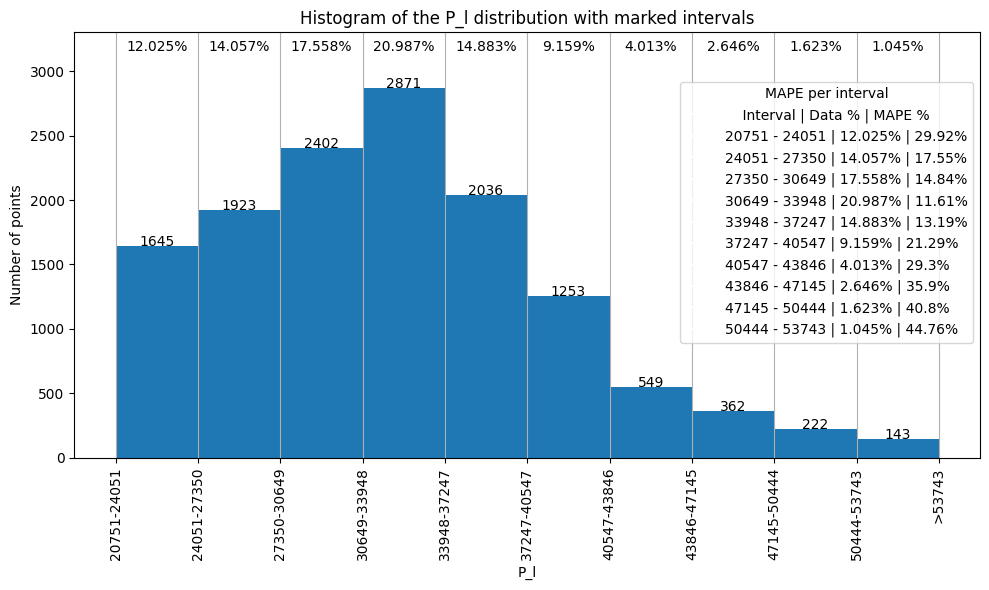

In [18]:
# Histogram of data distribution in df_only_gaps by intervals
import matplotlib.pyplot as plt
import numpy as np
import math as m

def create_intervals(load_intervals):
    intervals = []
    for i in range(len(load_intervals) - 1):
        low_interval = load_intervals[i]
        high_interval = load_intervals[i + 1]
        intervals.append((low_interval, high_interval))
    return intervals

intervals = create_intervals(load_intervals)
print(mape_by_interval)
new_mape_by_interval = []
print(intervals)
for i in range(len(intervals)):
    new_mape_by_interval.append((intervals[i], mape_by_interval[i][1]))

mape_by_interval = new_mape_by_interval

data = df_only_gaps['P_l']

plt.figure(figsize=(10, 6))

n, bins, patches = plt.hist(data, bins=[interval[0] for interval in intervals] + [intervals[-1][1]])

plt.xlabel('P_l')
plt.ylabel('Number of points')
plt.title('Histogram of the P_l distribution with marked intervals')

plt.xticks([interval[0] for interval in intervals] + [intervals[-1][1]],
           [f'{m.ceil(interval[0])}-{m.ceil(interval[1])}' for interval in intervals] + [f'>{m.ceil(intervals[-1][1])}'],
           rotation=90)

plt.grid(axis='x')

total_samples = len(data)
for i, interval in enumerate(intervals):
    count_in_interval = ((data >= interval[0]) & (data <= interval[1])).sum()
    percentage = count_in_interval / total_samples
    width = bins[i + 1] - bins[i]
    plt.text(bins[i] + width / 2, np.max(n) * 1.1, f'{round(percentage * 100, 3)}%', ha='center')  # Уменьшение координаты y для текста процентов
    plt.text(bins[i] + (bins[i + 1] - bins[i]) / 2, count_in_interval, f'{count_in_interval}', ha='center')

plt.plot([], [], label='    Interval | Data % | MAPE %', color='white')

for interval, value in mape_by_interval:
    count_in_interval = ((data >= interval[0]) & (data <= interval[1])).sum()
    percentage = count_in_interval / total_samples
    label = f'{m.ceil(interval[0])} - {m.ceil(interval[1])} | {round(percentage*100, 3)}% | {round(value, 2)}%'
    plt.plot([], [], label=label, color='white')

plt.legend(title='MAPE per interval', facecolor='white', bbox_to_anchor=(1, 0.9))

plt.ylim(0, np.max(n) * 1.15)

plt.tight_layout()

plt.savefig('histogram.png')

plt.show()

In [9]:
df_only_filled = filled_df.loc[drop_indexes]
df_orig_cut = df_orig.loc[drop_indexes]

for interval in range(0, 10):
    orig_values = df_orig_cut[df_orig_cut['P_l_interval'] == interval]['P_l']
    filled_values = df_only_filled[df_only_filled['P_l_interval'] == interval]['P_l']
    rmse = np.sqrt(mean_squared_error(orig_values, filled_values))
    r2 = r2_score(orig_values, filled_values)
    mae = mean_absolute_error(orig_values, filled_values)
    mape_by_interval[interval] = list(mape_by_interval[interval])
    mape_by_interval[interval].append(rmse)
    mape_by_interval[interval].append(r2)
    mape_by_interval[interval].append(mae)

start_interval = []
end_interval = []
mape = []
rmse = []
r2 = []
mae = []

for i in range(len(mape_by_interval)):
    start_interval.append(mape_by_interval[i][0][0])
    end_interval.append(mape_by_interval[i][0][1])
    mape.append(mape_by_interval[i][1])
    rmse.append(mape_by_interval[i][2])
    r2.append(mape_by_interval[i][3])
    mae.append(mape_by_interval[i][4])

df_error = pd.DataFrame(columns=['Start Interval', 'End Interval', 'MAPE', 'RMSE', 'R2', 'MAE'])

df_error['Start Interval'], df_error['End Interval'], df_error['MAPE'], df_error['RMSE'], df_error['R2'], df_error['MAE'] = start_interval, end_interval, mape, rmse, r2, mae

df_error.to_csv(f'error_{gaps_percent}_gaps.csv')

df_error

,Start Interval,End Interval,MAPE,RMSE,R2,MAE
0,14568.02430,16766.65307,10.252256,2712.278947,-23.395911,1671.178724
1,16766.65307,18965.28184,10.073883,2831.085877,-25.302684,1808.890134
2,18965.28184,21163.91061,16.308390,4698.427117,-70.922294,3282.876240
3,21163.91061,23362.53938,16.195801,4757.945766,-71.536651,3555.080445
4,23362.53938,25561.16815,13.266049,4195.753500,-58.443050,3154.458292
5,25561.16815,27759.79692,11.911019,4071.459232,-52.203549,3071.433191
6,27759.79692,29958.42569,12.983972,4498.611954,-60.356123,3606.014359
7,29958.42569,32157.05446,15.281787,5343.325816,-91.117960,4538.744910
8,32157.05446,34355.68323,16.014082,5811.027865,-105.163453,5056.784952
9,34355.68323,36554.31200,15.096548,6126.231734,-115.728314,5049.473056


In [10]:
# Сохранение df_filled в файл CSV
filled_df.to_csv('/Users/dmitrii/Desktop/PhD/Python/PhD_code_project/Machine-Learning-Techniques-for-Ensuring-the-Health-of-Citizens/notebooks/results/filled_with_HDIRT.csv', index=True)


OSError: Cannot save file into a non-existent directory: '/Users/dmitrii/Desktop/PhD/Python/PhD_code_project/Machine-Learning-Techniques-for-Ensuring-the-Health-of-Citizens/notebooks/results'